<a href="https://www.kaggle.com/code/w1ndness/data-analysis-07-lstm?scriptVersionId=109270742" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electrical-energy-load/test/1.csv
/kaggle/input/electrical-energy-load/test/3.csv
/kaggle/input/electrical-energy-load/test/.pdf
/kaggle/input/electrical-energy-load/test/2-1.csv
/kaggle/input/electrical-energy-load/test/2-2.csv
/kaggle/input/electrical-energy-load/train/1.csv
/kaggle/input/electrical-energy-load/train/3.csv
/kaggle/input/electrical-energy-load/train/2.csv


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
!nvidia-smi

Thu Oct 27 07:35:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Question 1

In [4]:
!rm -f model*

In [5]:
train_data = pd.read_csv('/kaggle/input/electrical-energy-load/train/1.csv')
test_data = pd.read_csv('/kaggle/input/electrical-energy-load/test/1.csv', encoding='gb2312')

In [6]:
train_data.head()

,数据时间,总有功功率（kw）
0,2018/1/1 00:00:00,244033.7682
1,2018/1/1 00:15:00,232720.6402
2,2018/1/1 00:30:00,231685.6891
3,2018/1/1 00:45:00,227581.3317
4,2018/1/1 01:00:00,233482.4269


In [7]:
train_data.columns = ['Date', 'Power']
train_data.head()

,Date,Power
0,2018/1/1 00:00:00,244033.7682
1,2018/1/1 00:15:00,232720.6402
2,2018/1/1 00:30:00,231685.6891
3,2018/1/1 00:45:00,227581.3317
4,2018/1/1 01:00:00,233482.4269


In [8]:
train_data.shape

(128156, 2)

In [9]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
grouper = pd.Grouper(key='Date', freq='15min')
train_data = train_data.groupby(grouper).first()
train_data.head()

,Power
Date,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269


In [10]:
train_data.shape

(128544, 1)

In [11]:
train_data.isnull().sum()

Power    388
dtype: int64

In [12]:
train_data['Power'] = train_data['Power'].interpolate()
train_data.isnull().sum()

Power    0
dtype: int64

In [13]:
train_data.to_csv('15min_freq.csv')

<AxesSubplot:xlabel='Date', ylabel='Power'>

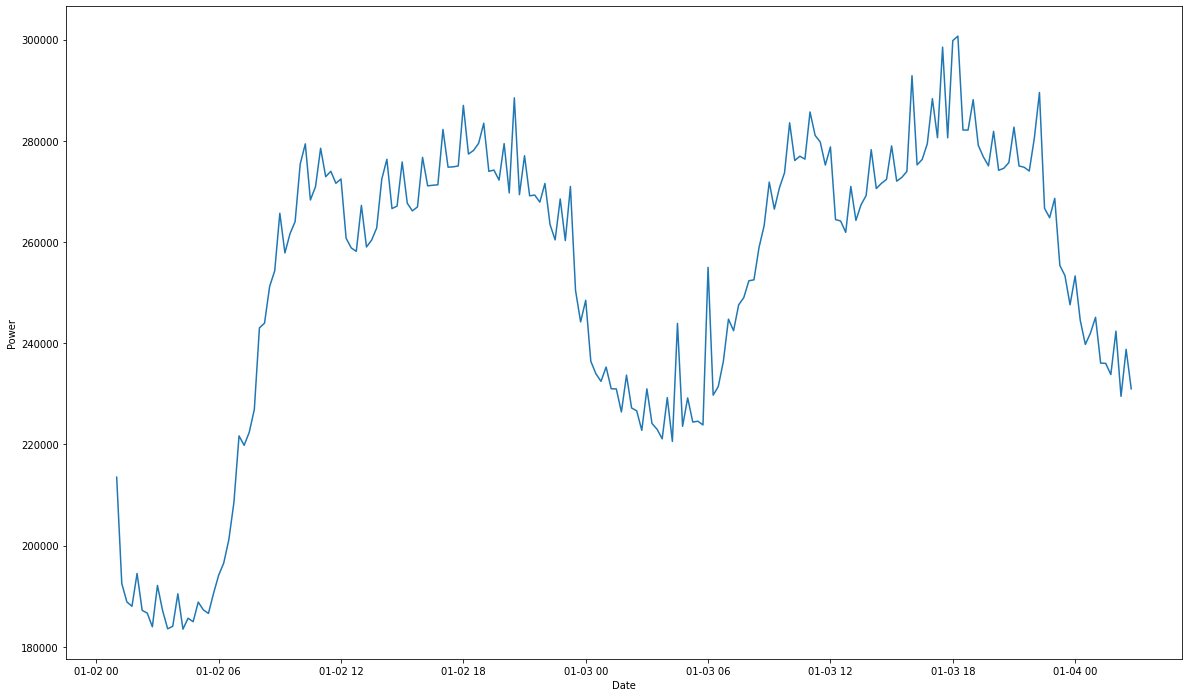

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
sns.lineplot(data=train_data[100:300], x='Date', y='Power', ax=ax[0][0])
sns.lineplot(data=train_data[:1000], x='Date', y='Power', ax=ax[0][1])
sns.lineplot(data=train_data[:10000], x='Date', y='Power', ax=ax[1][0])
sns.lineplot(data=train_data, x='Date', y='Power', ax=ax[1][1])

In [15]:
def split_dataset(data, train_size=.8, valid_size=.1):
    data_size = len(data)
    X_train = data[:int(data_size * train_size)]
    X_valid = data[int(data_size * train_size):int(data_size * train_size) + int(data_size * valid_size)]
    X_test = data[int(data_size * train_size) + int(data_size * valid_size):]
    return X_train, X_valid, X_test

In [16]:
train_bin, valid_bin, test_bin = split_dataset(train_data)

In [17]:
from sklearn.preprocessing import MinMaxScaler

train_scaler = MinMaxScaler()
valid_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

train_bin = train_scaler.fit_transform(train_bin)
valid_bin = valid_scaler.fit_transform(valid_bin)
test_bin = test_scaler.fit_transform(test_bin)

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size].ravel())
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [19]:
window_size, predict_size = 96, 1

X_train, y_train = preprocessing(train_bin, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_bin, window_size, predict_size)
X_test, y_test = preprocessing(test_bin, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [20]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([102738, 96, 1]),
 torch.Size([12757, 96, 1]),
 torch.Size([12758, 96, 1]))

In [21]:
USE_MULTI_GPU = False

if USE_MULTI_GPU and torch.cuda.device_count() > 1:
    MULTI_GPU = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
    device_ids = [0, 1]
else:
    MULTI_GPU = False

num_gpus = 2 if MULTI_GPU else 1    
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [23]:
from torch import nn
from torch.nn import functional as F

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
#         self.reg = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                  nn.ReLU(),
#                                  nn.Linear(self.hidden_size // 2, self.output_size))
#         self.fc1 = nn.Linear(self.hidden_size, self.hidden_size // 2)
#         self.fc2 = nn.Linear(self.hidden_size // 2, self.hidden_size // 4)
#         self.fc3 = nn.Linear(self.hidden_size // 4, self.output_size)
    
    def forward(self, X):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(X, (h_0, c_0))
#         print(output.shape)
        o = output[:, -1, :]
#         pred = self.reg(o)
        pred = self.linear(o)
        return pred

In [24]:
from tqdm import tqdm

def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
#             if step == 0:
#                 print(y_hat, y)
            l = loss(y_hat, y)
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 100 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
#                 print(y_hat)
            l = loss(y_hat, y)
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            print('New best performance... Save new model checkpoint.')
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss


In [25]:
params = {'input_size': 1,
          'hidden_size': 64,
          'output_size': predict_size,
          'num_layers': 2, 
          'learning_rate': 0.1,
          'weight_decay': 1e-3,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 50}

In [26]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model.pth')

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


  0%|          | 0/50 [00:00<?, ?it/s]

Step 0, train loss 0.305840
Step 100, train loss 0.021659
Step 200, train loss 0.013103
Step 300, train loss 0.018464
Step 400, train loss 0.011654
Step 500, train loss 0.012892
Step 600, train loss 0.014039
Step 700, train loss 0.019500
Step 800, train loss 0.013827


  2%|▏         | 1/50 [00:09<08:08,  9.96s/it]

New best performance... Save new model checkpoint.
Epoch [1/50], train loss 0.037928, valid loss 0.023393. Now best: 0.023393
Step 0, train loss 0.017598
Step 100, train loss 0.018021
Step 200, train loss 0.044459
Step 300, train loss 0.018694
Step 400, train loss 0.016888
Step 500, train loss 0.015060
Step 600, train loss 0.017216
Step 700, train loss 0.011750
Step 800, train loss 0.019993


  4%|▍         | 2/50 [00:18<07:07,  8.91s/it]

Epoch [2/50], train loss 0.026038, valid loss 0.026807. Now best: 0.023393
Step 0, train loss 0.017732
Step 100, train loss 0.013257
Step 200, train loss 0.015904
Step 300, train loss 0.011393
Step 400, train loss 0.009654
Step 500, train loss 0.002364
Step 600, train loss 0.002674
Step 700, train loss 0.002510
Step 800, train loss 0.002583


  6%|▌         | 3/50 [00:26<06:41,  8.53s/it]

New best performance... Save new model checkpoint.
Epoch [3/50], train loss 0.009822, valid loss 0.003486. Now best: 0.003486
Step 0, train loss 0.002583
Step 100, train loss 0.000992
Step 200, train loss 0.001045
Step 300, train loss 0.001426
Step 400, train loss 0.002100
Step 500, train loss 0.001794
Step 600, train loss 0.000871
Step 700, train loss 0.001690
Step 800, train loss 0.001055


  8%|▊         | 4/50 [00:34<06:28,  8.45s/it]

New best performance... Save new model checkpoint.
Epoch [4/50], train loss 0.001845, valid loss 0.002098. Now best: 0.002098
Step 0, train loss 0.001146
Step 100, train loss 0.001072
Step 200, train loss 0.001045
Step 300, train loss 0.001602
Step 400, train loss 0.000918
Step 500, train loss 0.001103
Step 600, train loss 0.001109
Step 700, train loss 0.001129
Step 800, train loss 0.002335


 10%|█         | 5/50 [00:43<06:30,  8.67s/it]

New best performance... Save new model checkpoint.
Epoch [5/50], train loss 0.001328, valid loss 0.001765. Now best: 0.001765
Step 0, train loss 0.001831
Step 100, train loss 0.001223
Step 200, train loss 0.000937
Step 300, train loss 0.002298
Step 400, train loss 0.000727
Step 500, train loss 0.001228
Step 600, train loss 0.003936
Step 700, train loss 0.001663
Step 800, train loss 0.001242


 12%|█▏        | 6/50 [00:51<06:14,  8.52s/it]

New best performance... Save new model checkpoint.
Epoch [6/50], train loss 0.001334, valid loss 0.001748. Now best: 0.001748
Step 0, train loss 0.001638
Step 100, train loss 0.001037
Step 200, train loss 0.001057
Step 300, train loss 0.000739
Step 400, train loss 0.000811
Step 500, train loss 0.001821
Step 600, train loss 0.001310
Step 700, train loss 0.001120
Step 800, train loss 0.001028


 14%|█▍        | 7/50 [00:59<06:01,  8.40s/it]

New best performance... Save new model checkpoint.
Epoch [7/50], train loss 0.001273, valid loss 0.001701. Now best: 0.001701
Step 0, train loss 0.000898
Step 100, train loss 0.002054
Step 200, train loss 0.000966
Step 300, train loss 0.000855
Step 400, train loss 0.001027
Step 500, train loss 0.001018
Step 600, train loss 0.000927
Step 700, train loss 0.000945
Step 800, train loss 0.002524


 16%|█▌        | 8/50 [01:08<05:54,  8.43s/it]

Epoch [8/50], train loss 0.001272, valid loss 0.001701. Now best: 0.001701
Step 0, train loss 0.001013
Step 100, train loss 0.001819
Step 200, train loss 0.001041
Step 300, train loss 0.001005
Step 400, train loss 0.001797
Step 500, train loss 0.001062
Step 600, train loss 0.000983
Step 700, train loss 0.002382
Step 800, train loss 0.000901


 18%|█▊        | 9/50 [01:18<06:12,  9.08s/it]

Epoch [9/50], train loss 0.001264, valid loss 0.001724. Now best: 0.001701
Step 0, train loss 0.001033
Step 100, train loss 0.000961
Step 200, train loss 0.001505
Step 300, train loss 0.000972
Step 400, train loss 0.001057
Step 500, train loss 0.001575
Step 600, train loss 0.000906
Step 700, train loss 0.000899
Step 800, train loss 0.000780


 20%|██        | 10/50 [01:29<06:20,  9.51s/it]

New best performance... Save new model checkpoint.
Epoch [10/50], train loss 0.001261, valid loss 0.001700. Now best: 0.001700
Step 0, train loss 0.001026
Step 100, train loss 0.002091
Step 200, train loss 0.001092
Step 300, train loss 0.000839
Step 400, train loss 0.001008
Step 500, train loss 0.001059
Step 600, train loss 0.000835
Step 700, train loss 0.001068
Step 800, train loss 0.001152


 22%|██▏       | 11/50 [01:39<06:18,  9.70s/it]

Epoch [11/50], train loss 0.001260, valid loss 0.001707. Now best: 0.001700
Step 0, train loss 0.000917
Step 100, train loss 0.000846
Step 200, train loss 0.001091
Step 300, train loss 0.000726
Step 400, train loss 0.000866
Step 500, train loss 0.001010
Step 600, train loss 0.001074
Step 700, train loss 0.001238
Step 800, train loss 0.000883


 24%|██▍       | 12/50 [01:48<06:01,  9.52s/it]

Epoch [12/50], train loss 0.001260, valid loss 0.001712. Now best: 0.001700
Step 0, train loss 0.000971
Step 100, train loss 0.001294
Step 200, train loss 0.002063
Step 300, train loss 0.002232
Step 400, train loss 0.001242
Step 500, train loss 0.000771
Step 600, train loss 0.000937
Step 700, train loss 0.000856
Step 800, train loss 0.001044


 26%|██▌       | 13/50 [01:57<05:43,  9.29s/it]

Epoch [13/50], train loss 0.001262, valid loss 0.001704. Now best: 0.001700
Step 0, train loss 0.001082
Step 100, train loss 0.000818
Step 200, train loss 0.000982
Step 300, train loss 0.000903
Step 400, train loss 0.001059
Step 500, train loss 0.000665
Step 600, train loss 0.000810
Step 700, train loss 0.000838
Step 800, train loss 0.000866


 28%|██▊       | 14/50 [02:06<05:29,  9.15s/it]

Epoch [14/50], train loss 0.001263, valid loss 0.001723. Now best: 0.001700
Step 0, train loss 0.000901
Step 100, train loss 0.000868
Step 200, train loss 0.001676
Step 300, train loss 0.001035
Step 400, train loss 0.001154
Step 500, train loss 0.000672
Step 600, train loss 0.000957
Step 700, train loss 0.001089
Step 800, train loss 0.000907


 30%|███       | 15/50 [02:14<05:13,  8.97s/it]

Epoch [15/50], train loss 0.001265, valid loss 0.001713. Now best: 0.001700
Step 0, train loss 0.005012
Step 100, train loss 0.001042
Step 200, train loss 0.000825
Step 300, train loss 0.001102
Step 400, train loss 0.000757
Step 500, train loss 0.002842
Step 600, train loss 0.001572
Step 700, train loss 0.001598
Step 800, train loss 0.000869


 32%|███▏      | 16/50 [02:22<04:54,  8.65s/it]

Epoch [16/50], train loss 0.001265, valid loss 0.001719. Now best: 0.001700
Step 0, train loss 0.001123
Step 100, train loss 0.001207
Step 200, train loss 0.000971
Step 300, train loss 0.001242
Step 400, train loss 0.001218
Step 500, train loss 0.000756
Step 600, train loss 0.001197
Step 700, train loss 0.000790
Step 800, train loss 0.001454


 34%|███▍      | 17/50 [02:31<04:42,  8.55s/it]

Epoch [17/50], train loss 0.001259, valid loss 0.001720. Now best: 0.001700
Step 0, train loss 0.001013
Step 100, train loss 0.001284
Step 200, train loss 0.001457
Step 300, train loss 0.001014
Step 400, train loss 0.001061
Step 500, train loss 0.000820
Step 600, train loss 0.001169
Step 700, train loss 0.000961
Step 800, train loss 0.000993


 36%|███▌      | 18/50 [02:39<04:32,  8.51s/it]

Epoch [18/50], train loss 0.001260, valid loss 0.001711. Now best: 0.001700
Step 0, train loss 0.001204
Step 100, train loss 0.001209
Step 200, train loss 0.002410
Step 300, train loss 0.001218
Step 400, train loss 0.000971
Step 500, train loss 0.001030
Step 600, train loss 0.000912
Step 700, train loss 0.000987
Step 800, train loss 0.000847


 38%|███▊      | 19/50 [02:47<04:21,  8.44s/it]

New best performance... Save new model checkpoint.
Epoch [19/50], train loss 0.001260, valid loss 0.001691. Now best: 0.001691
Step 0, train loss 0.000885
Step 100, train loss 0.001033
Step 200, train loss 0.001461
Step 300, train loss 0.000983
Step 400, train loss 0.001068
Step 500, train loss 0.001088
Step 600, train loss 0.000891
Step 700, train loss 0.000911
Step 800, train loss 0.001722


 40%|████      | 20/50 [02:55<04:08,  8.27s/it]

Epoch [20/50], train loss 0.001259, valid loss 0.001724. Now best: 0.001691
Step 0, train loss 0.000941
Step 100, train loss 0.002572
Step 200, train loss 0.001603
Step 300, train loss 0.001203
Step 400, train loss 0.001647
Step 500, train loss 0.001447
Step 600, train loss 0.001218
Step 700, train loss 0.001219
Step 800, train loss 0.002160


 42%|████▏     | 21/50 [03:03<03:58,  8.21s/it]

Epoch [21/50], train loss 0.001263, valid loss 0.001710. Now best: 0.001691
Step 0, train loss 0.000917
Step 100, train loss 0.000861
Step 200, train loss 0.000845
Step 300, train loss 0.001186
Step 400, train loss 0.001070
Step 500, train loss 0.001194
Step 600, train loss 0.000919
Step 700, train loss 0.001814
Step 800, train loss 0.001627


 44%|████▍     | 22/50 [03:12<03:54,  8.36s/it]

Epoch [22/50], train loss 0.001260, valid loss 0.001711. Now best: 0.001691
Step 0, train loss 0.000838
Step 100, train loss 0.003305
Step 200, train loss 0.000921
Step 300, train loss 0.001028
Step 400, train loss 0.000797
Step 500, train loss 0.001345
Step 600, train loss 0.001188
Step 700, train loss 0.000955
Step 800, train loss 0.000932


 46%|████▌     | 23/50 [03:20<03:41,  8.22s/it]

Epoch [23/50], train loss 0.001257, valid loss 0.001731. Now best: 0.001691
Step 0, train loss 0.001144
Step 100, train loss 0.000963
Step 200, train loss 0.000959
Step 300, train loss 0.001808
Step 400, train loss 0.001338
Step 500, train loss 0.000872
Step 600, train loss 0.001572
Step 700, train loss 0.000974
Step 800, train loss 0.001175


 48%|████▊     | 24/50 [03:28<03:33,  8.23s/it]

Epoch [24/50], train loss 0.001263, valid loss 0.001707. Now best: 0.001691
Step 0, train loss 0.001038
Step 100, train loss 0.000874
Step 200, train loss 0.001165
Step 300, train loss 0.001807
Step 400, train loss 0.001098
Step 500, train loss 0.000865
Step 600, train loss 0.001281
Step 700, train loss 0.000688
Step 800, train loss 0.000768


 50%|█████     | 25/50 [03:36<03:25,  8.23s/it]

Epoch [25/50], train loss 0.001264, valid loss 0.001703. Now best: 0.001691
Step 0, train loss 0.001070
Step 100, train loss 0.001078
Step 200, train loss 0.001115
Step 300, train loss 0.000894
Step 400, train loss 0.001180
Step 500, train loss 0.000845
Step 600, train loss 0.000784
Step 700, train loss 0.001002
Step 800, train loss 0.002245


 52%|█████▏    | 26/50 [03:45<03:20,  8.37s/it]

Epoch [26/50], train loss 0.001260, valid loss 0.001722. Now best: 0.001691
Step 0, train loss 0.000926
Step 100, train loss 0.000918
Step 200, train loss 0.001143
Step 300, train loss 0.001261
Step 400, train loss 0.001008
Step 500, train loss 0.001090
Step 600, train loss 0.002050
Step 700, train loss 0.000890
Step 800, train loss 0.001738


 54%|█████▍    | 27/50 [03:53<03:08,  8.19s/it]

Epoch [27/50], train loss 0.001261, valid loss 0.001708. Now best: 0.001691
Step 0, train loss 0.001276
Step 100, train loss 0.001015
Step 200, train loss 0.001929
Step 300, train loss 0.001023
Step 400, train loss 0.001290
Step 500, train loss 0.002227
Step 600, train loss 0.001170
Step 700, train loss 0.001335
Step 800, train loss 0.003448


 56%|█████▌    | 28/50 [04:01<02:59,  8.18s/it]

Epoch [28/50], train loss 0.001265, valid loss 0.001705. Now best: 0.001691
Step 0, train loss 0.003356
Step 100, train loss 0.001072
Step 200, train loss 0.000985
Step 300, train loss 0.002227
Step 400, train loss 0.001306
Step 500, train loss 0.000866
Step 600, train loss 0.000877
Step 700, train loss 0.000872
Step 800, train loss 0.001115


 58%|█████▊    | 29/50 [04:09<02:52,  8.20s/it]

Epoch [29/50], train loss 0.001264, valid loss 0.001705. Now best: 0.001691
Step 0, train loss 0.000750
Step 100, train loss 0.000921
Step 200, train loss 0.001619
Step 300, train loss 0.002334
Step 400, train loss 0.000845
Step 500, train loss 0.001166
Step 600, train loss 0.001253
Step 700, train loss 0.001067
Step 800, train loss 0.001149


 60%|██████    | 30/50 [04:18<02:46,  8.31s/it]

Epoch [30/50], train loss 0.001264, valid loss 0.001710. Now best: 0.001691
Step 0, train loss 0.002597
Step 100, train loss 0.001120
Step 200, train loss 0.002376
Step 300, train loss 0.000981
Step 400, train loss 0.001215
Step 500, train loss 0.000879
Step 600, train loss 0.000978
Step 700, train loss 0.001155
Step 800, train loss 0.001092


 62%|██████▏   | 31/50 [04:26<02:35,  8.17s/it]

Epoch [31/50], train loss 0.001257, valid loss 0.001716. Now best: 0.001691
Step 0, train loss 0.002509
Step 100, train loss 0.001106
Step 200, train loss 0.000733
Step 300, train loss 0.000701
Step 400, train loss 0.001919
Step 500, train loss 0.001779
Step 600, train loss 0.001896
Step 700, train loss 0.001269
Step 800, train loss 0.001132


 64%|██████▍   | 32/50 [04:34<02:26,  8.13s/it]

Epoch [32/50], train loss 0.001262, valid loss 0.001719. Now best: 0.001691
Step 0, train loss 0.000975
Step 100, train loss 0.001045
Step 200, train loss 0.000872
Step 300, train loss 0.002714
Step 400, train loss 0.001536
Step 500, train loss 0.001009
Step 600, train loss 0.003180
Step 700, train loss 0.000755
Step 800, train loss 0.001164


 66%|██████▌   | 33/50 [04:42<02:18,  8.14s/it]

Epoch [33/50], train loss 0.001261, valid loss 0.001705. Now best: 0.001691
Step 0, train loss 0.001264
Step 100, train loss 0.001107
Step 200, train loss 0.001126
Step 300, train loss 0.001347
Step 400, train loss 0.001105
Step 500, train loss 0.000915
Step 600, train loss 0.001781
Step 700, train loss 0.000914
Step 800, train loss 0.001173


 68%|██████▊   | 34/50 [04:51<02:13,  8.32s/it]

Epoch [34/50], train loss 0.001258, valid loss 0.001706. Now best: 0.001691
Step 0, train loss 0.001169
Step 100, train loss 0.001273
Step 200, train loss 0.001452
Step 300, train loss 0.000902
Step 400, train loss 0.001158
Step 500, train loss 0.000765
Step 600, train loss 0.000965
Step 700, train loss 0.002569
Step 800, train loss 0.000935


 70%|███████   | 35/50 [04:58<02:02,  8.18s/it]

Epoch [35/50], train loss 0.001258, valid loss 0.001714. Now best: 0.001691
Step 0, train loss 0.002846
Step 100, train loss 0.000702
Step 200, train loss 0.001449
Step 300, train loss 0.000584
Step 400, train loss 0.001138
Step 500, train loss 0.004015
Step 600, train loss 0.001131
Step 700, train loss 0.000955
Step 800, train loss 0.000721


 72%|███████▏  | 36/50 [05:07<01:54,  8.18s/it]

Epoch [36/50], train loss 0.001262, valid loss 0.001714. Now best: 0.001691
Step 0, train loss 0.001152
Step 100, train loss 0.000974
Step 200, train loss 0.001022
Step 300, train loss 0.001469
Step 400, train loss 0.001431
Step 500, train loss 0.001254
Step 600, train loss 0.001244
Step 700, train loss 0.001449
Step 800, train loss 0.001009


 74%|███████▍  | 37/50 [05:14<01:45,  8.10s/it]

Epoch [37/50], train loss 0.001266, valid loss 0.001705. Now best: 0.001691
Step 0, train loss 0.001088
Step 100, train loss 0.000911
Step 200, train loss 0.001120
Step 300, train loss 0.001107
Step 400, train loss 0.000707
Step 500, train loss 0.001000
Step 600, train loss 0.000845
Step 700, train loss 0.002070
Step 800, train loss 0.004032


 76%|███████▌  | 38/50 [05:23<01:38,  8.23s/it]

Epoch [38/50], train loss 0.001261, valid loss 0.001716. Now best: 0.001691
Step 0, train loss 0.001804
Step 100, train loss 0.001847
Step 200, train loss 0.000944
Step 300, train loss 0.001158
Step 400, train loss 0.001005
Step 500, train loss 0.002393
Step 600, train loss 0.000926
Step 700, train loss 0.000769
Step 800, train loss 0.001167


 78%|███████▊  | 39/50 [05:31<01:29,  8.10s/it]

Epoch [39/50], train loss 0.001265, valid loss 0.001725. Now best: 0.001691
Step 0, train loss 0.001826
Step 100, train loss 0.001821
Step 200, train loss 0.000733
Step 300, train loss 0.001095
Step 400, train loss 0.000917
Step 500, train loss 0.001132
Step 600, train loss 0.001465
Step 700, train loss 0.001012
Step 800, train loss 0.001706


 80%|████████  | 40/50 [05:39<01:20,  8.10s/it]

Epoch [40/50], train loss 0.001266, valid loss 0.001707. Now best: 0.001691
Step 0, train loss 0.000781
Step 100, train loss 0.000984
Step 200, train loss 0.000868
Step 300, train loss 0.000967
Step 400, train loss 0.001158
Step 500, train loss 0.000835
Step 600, train loss 0.001768
Step 700, train loss 0.001139
Step 800, train loss 0.000935


 82%|████████▏ | 41/50 [05:47<01:12,  8.07s/it]

Epoch [41/50], train loss 0.001258, valid loss 0.001710. Now best: 0.001691
Step 0, train loss 0.001131
Step 100, train loss 0.000819
Step 200, train loss 0.001168
Step 300, train loss 0.001501
Step 400, train loss 0.001438
Step 500, train loss 0.001036
Step 600, train loss 0.001783
Step 700, train loss 0.000863
Step 800, train loss 0.000828


 84%|████████▍ | 42/50 [05:56<01:06,  8.27s/it]

Epoch [42/50], train loss 0.001266, valid loss 0.001720. Now best: 0.001691
Step 0, train loss 0.000909
Step 100, train loss 0.002576
Step 200, train loss 0.000871
Step 300, train loss 0.001108
Step 400, train loss 0.001426
Step 500, train loss 0.000931
Step 600, train loss 0.001370
Step 700, train loss 0.001200
Step 800, train loss 0.001683


 86%|████████▌ | 43/50 [06:03<00:56,  8.12s/it]

Epoch [43/50], train loss 0.001262, valid loss 0.001706. Now best: 0.001691
Step 0, train loss 0.002092
Step 100, train loss 0.001045
Step 200, train loss 0.000969
Step 300, train loss 0.000748
Step 400, train loss 0.001028
Step 500, train loss 0.001088
Step 600, train loss 0.001327
Step 700, train loss 0.000892
Step 800, train loss 0.001056


 88%|████████▊ | 44/50 [06:12<00:48,  8.14s/it]

Epoch [44/50], train loss 0.001265, valid loss 0.001712. Now best: 0.001691
Step 0, train loss 0.001090
Step 100, train loss 0.000983
Step 200, train loss 0.000856
Step 300, train loss 0.001371
Step 400, train loss 0.000992
Step 500, train loss 0.003200
Step 600, train loss 0.000677
Step 700, train loss 0.001887
Step 800, train loss 0.001084


 90%|█████████ | 45/50 [06:20<00:40,  8.11s/it]

Epoch [45/50], train loss 0.001261, valid loss 0.001730. Now best: 0.001691
Step 0, train loss 0.001859
Step 100, train loss 0.001024
Step 200, train loss 0.001668
Step 300, train loss 0.001236
Step 400, train loss 0.001060
Step 500, train loss 0.001066
Step 600, train loss 0.000706
Step 700, train loss 0.001015
Step 800, train loss 0.000956


 92%|█████████▏| 46/50 [06:28<00:32,  8.18s/it]

Epoch [46/50], train loss 0.001268, valid loss 0.001721. Now best: 0.001691
Step 0, train loss 0.000980
Step 100, train loss 0.000978
Step 200, train loss 0.001386
Step 300, train loss 0.000967
Step 400, train loss 0.000945
Step 500, train loss 0.002319
Step 600, train loss 0.000840
Step 700, train loss 0.000996
Step 800, train loss 0.000866


 94%|█████████▍| 47/50 [06:36<00:24,  8.04s/it]

Epoch [47/50], train loss 0.001263, valid loss 0.001716. Now best: 0.001691
Step 0, train loss 0.002976
Step 100, train loss 0.001070
Step 200, train loss 0.001105
Step 300, train loss 0.001131
Step 400, train loss 0.001292
Step 500, train loss 0.000864
Step 600, train loss 0.003693
Step 700, train loss 0.001234
Step 800, train loss 0.000668


 96%|█████████▌| 48/50 [06:44<00:15,  7.99s/it]

Epoch [48/50], train loss 0.001259, valid loss 0.001723. Now best: 0.001691
Step 0, train loss 0.001270
Step 100, train loss 0.001469
Step 200, train loss 0.001111
Step 300, train loss 0.000932
Step 400, train loss 0.001012
Step 500, train loss 0.000792
Step 600, train loss 0.001360
Step 700, train loss 0.001149
Step 800, train loss 0.000999


 98%|█████████▊| 49/50 [06:52<00:08,  8.01s/it]

Epoch [49/50], train loss 0.001263, valid loss 0.001704. Now best: 0.001691
Step 0, train loss 0.001089
Step 100, train loss 0.001038
Step 200, train loss 0.000849
Step 300, train loss 0.000769
Step 400, train loss 0.001352
Step 500, train loss 0.000931
Step 600, train loss 0.001330
Step 700, train loss 0.001241
Step 800, train loss 0.001092


100%|██████████| 50/50 [07:00<00:00,  8.41s/it]

Epoch [50/50], train loss 0.001261, valid loss 0.001704. Now best: 0.001691


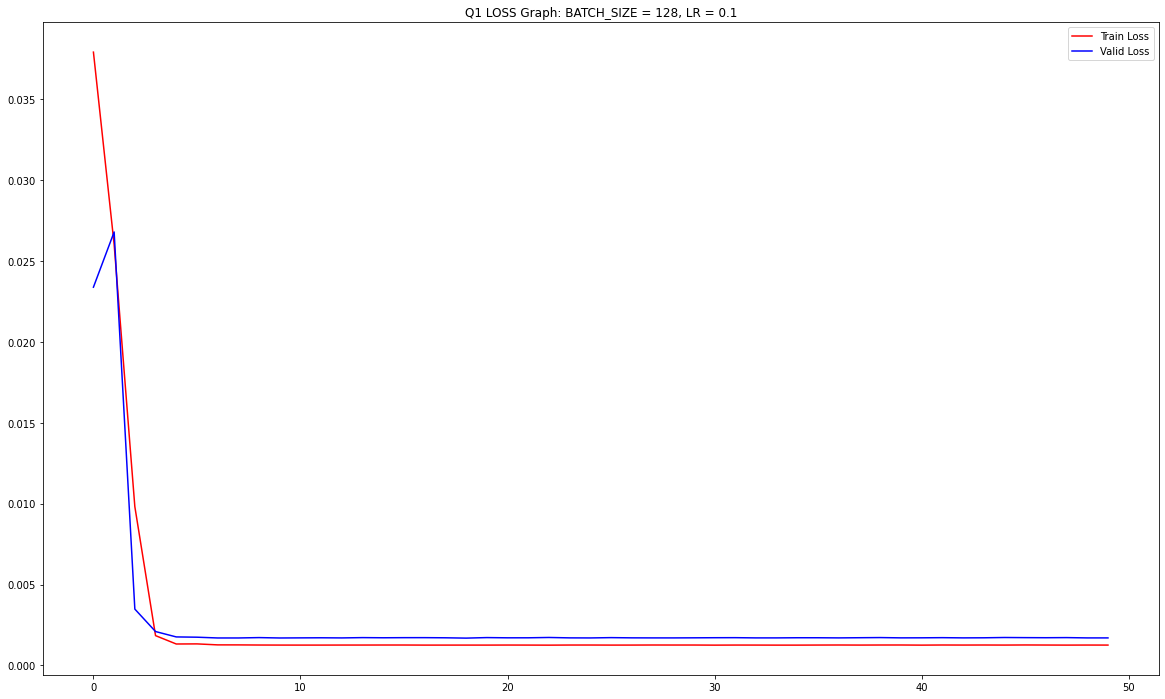

In [27]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q1 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [28]:
def mape(truths, preds):
    return np.mean(np.abs((truths - preds) / truths)) * 100

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [29]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for each in y:
            truths.append(each.cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for each in y_hat:
                preds.append(each.cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = test_scaler.inverse_transform(truths)
    preds = test_scaler.inverse_transform(preds)
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [30]:
truths, preds = test(params, test_loader, 'model.pth')

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


100%|██████████| 99/99 [00:01<00:00, 97.20it/s] 

MAPE: 5.3162552416324615
MAE: 10800.379
MSE: 230757970.0
R2 Score: 0.7168396256537389


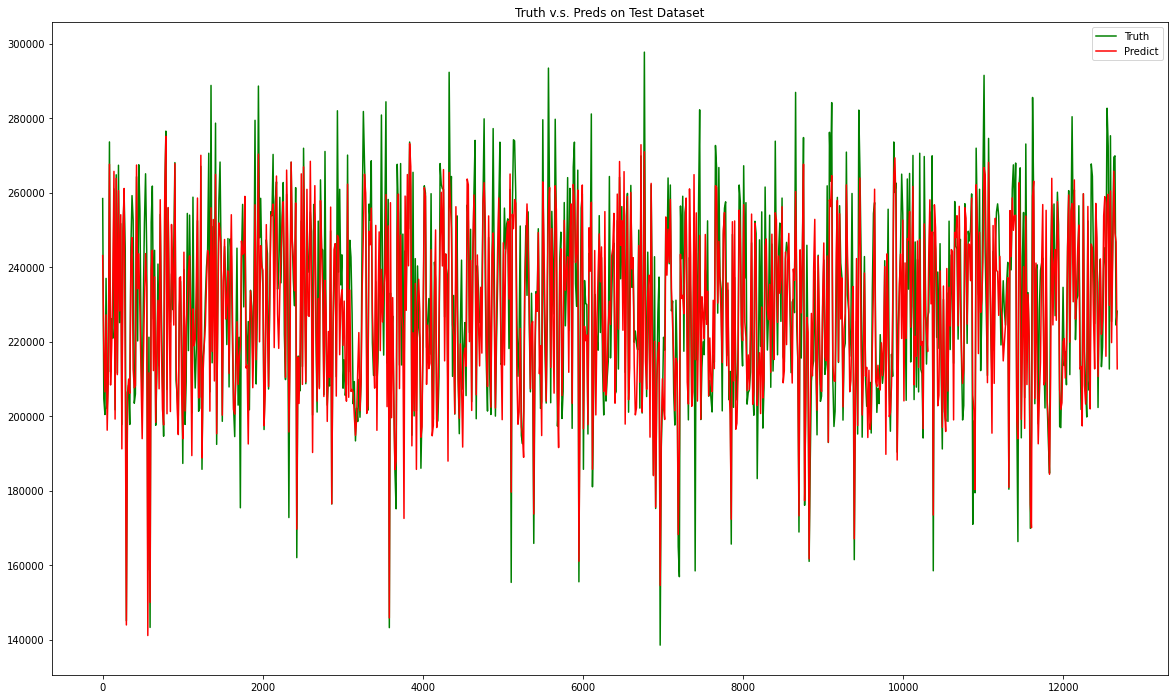

In [31]:
from scipy.interpolate import make_interp_spline

x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

# Question 2

In [32]:
df = pd.read_csv('15min_freq.csv')
df.head()

,Date,Power
0,2018-01-01 00:00:00,244033.7682
1,2018-01-01 00:15:00,232720.6402
2,2018-01-01 00:30:00,231685.6891
3,2018-01-01 00:45:00,227581.3317
4,2018-01-01 01:00:00,233482.4269


In [33]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute
df['Tick'] = df['Hour'] * 4 + df['Minute'] // 15
df.drop(columns=['Date'], inplace=True)
df.head()

,Power,Year,Month,Day,Hour,Minute,Tick
0,244033.7682,2018,1,1,0,0,0
1,232720.6402,2018,1,1,0,15,1
2,231685.6891,2018,1,1,0,30,2
3,227581.3317,2018,1,1,0,45,3
4,233482.4269,2018,1,1,1,0,4


In [34]:
groups = df.groupby(['Year', 'Month', 'Day'], as_index=False)
columns = ['Power', 'Year', 'Month', 'Day', 'Hour', 'Minute']
data_daily_max = pd.DataFrame(columns=columns)
data_daily_min = pd.DataFrame(columns=columns)
for group in groups:
    _, meta = group
    max_row = meta[meta['Power'] == meta['Power'].max()]
    min_row = meta[meta['Power'] == meta['Power'].min()]
    data_daily_max = pd.concat([data_daily_max, max_row], ignore_index=True)
    data_daily_min = pd.concat([data_daily_min, min_row], ignore_index=True)

In [35]:
data_daily_max.head()

,Power,Year,Month,Day,Hour,Minute,Tick
0,257733.9648,2018,1,1,19,45,79.0
1,288502.5947,2018,1,2,20,30,82.0
2,300698.5858,2018,1,3,18,15,73.0
3,293806.5077,2018,1,4,14,45,59.0
4,295075.2147,2018,1,5,18,30,74.0


In [36]:
data_daily_min.head()

,Power,Year,Month,Day,Hour,Minute,Tick
0,203793.5753,2018,1,1,8,15,33.0
1,183505.2648,2018,1,2,4,15,17.0
2,220601.5301,2018,1,3,4,15,17.0
3,224981.5866,2018,1,4,4,45,19.0
4,224667.8170,2018,1,5,4,15,17.0


Text(0.5, 1.0, 'Daily Power Max & Min')

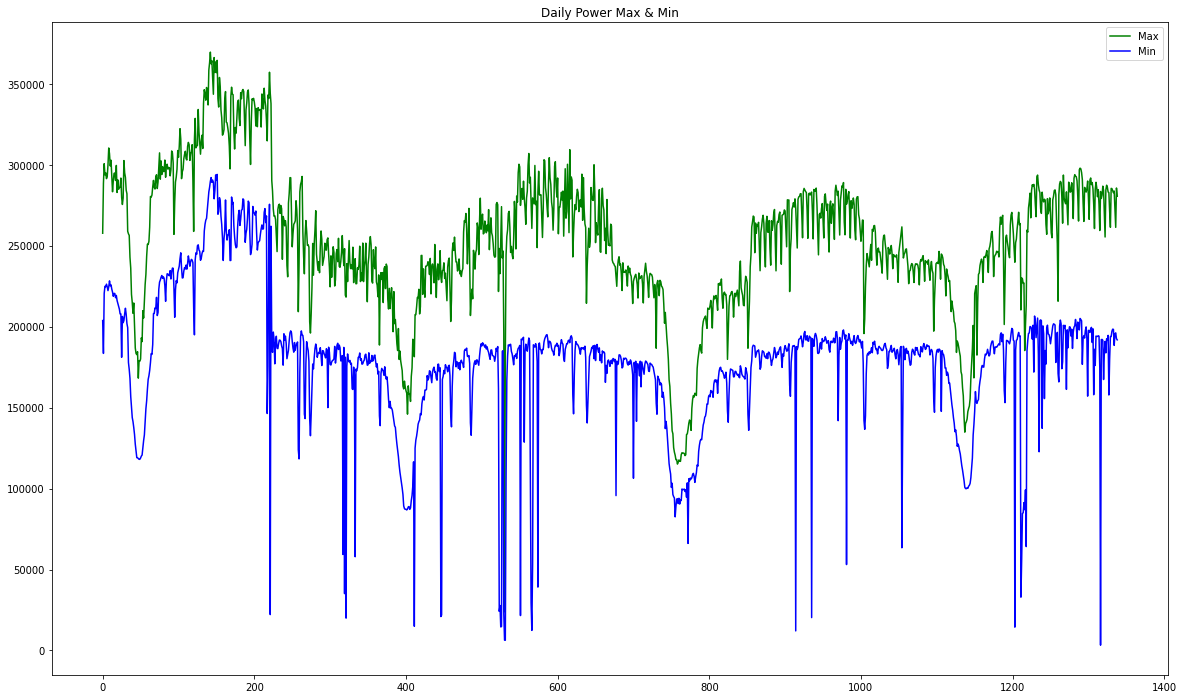

In [37]:
plt.figure(figsize=(20, 12))
x = np.arange(len(data_daily_max))
plt.plot(x, data_daily_max['Power'], c='g', label='Max')
plt.plot(x, data_daily_min['Power'], c='b', label='Min')
plt.legend()
plt.title('Daily Power Max & Min')

Text(0.5, 1.0, 'Daily Max and Min Time (As Tick)')

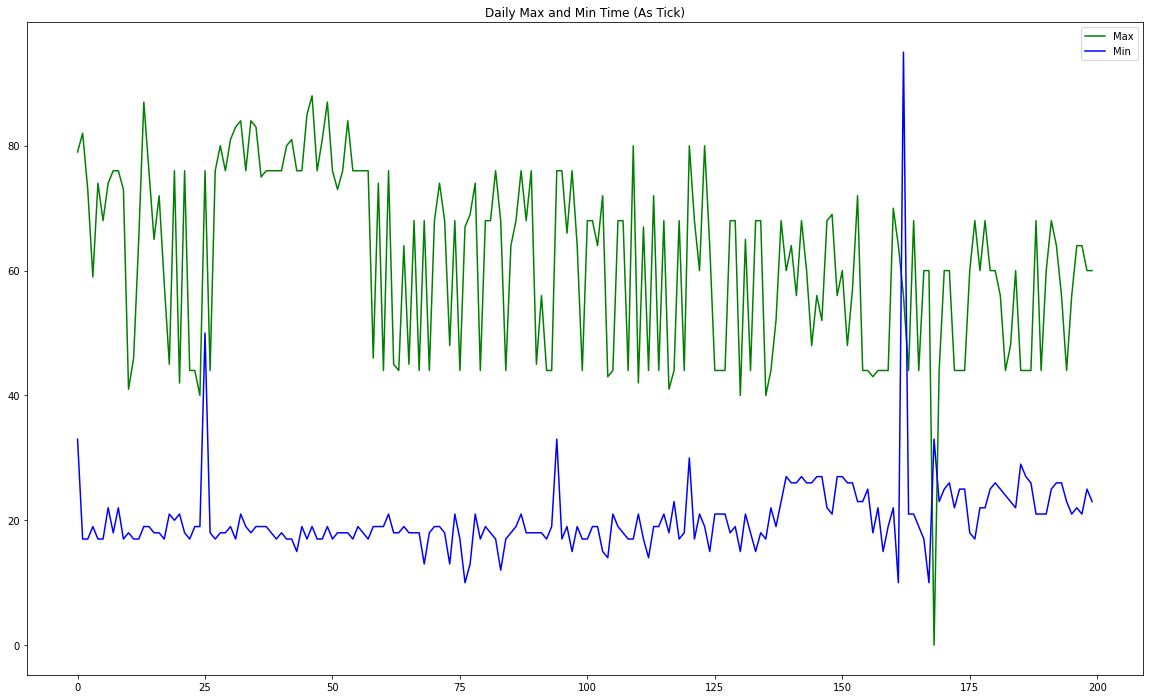

In [38]:
plt.figure(figsize=(20, 12))
x = np.arange(len(data_daily_max[:200]))
plt.plot(x, data_daily_max['Tick'][:200], c='g', label='Max')
plt.plot(x, data_daily_min['Tick'][:200], c='b', label='Min')
plt.legend()
plt.title('Daily Max and Min Time (As Tick)')

In [39]:
data_daily_max['Date'] = pd.to_datetime(data_daily_max[['Year', 'Month', 'Day']])
data_daily_min['Date'] = pd.to_datetime(data_daily_min[['Year', 'Month', 'Day']])

In [40]:
weather_data = pd.read_csv('../input/electrical-energy-load/train/3.csv')
weather_data.head()

,日期,天气状况,最高温度,最低温度,白天风力风向,夜晚风力风向
0,2018年1月1日,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
1,2018年1月1日,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
2,2018年1月2日,多云/多云,22℃,15℃,无持续风向<3级,无持续风向<3级
3,2018年1月3日,多云/阴,23℃,15℃,无持续风向<3级,无持续风向<3级
4,2018年1月4日,多云/小雨,21℃,16℃,无持续风向<3级,无持续风向<3级


In [41]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日期      1345 non-null   object
 1   天气状况    1345 non-null   object
 2   最高温度    1345 non-null   object
 3   最低温度    1345 non-null   object
 4   白天风力风向  1345 non-null   object
 5   夜晚风力风向  1345 non-null   object
dtypes: object(6)
memory usage: 63.2+ KB


In [42]:
weather_data.columns = ['Date', 'Weather', 'HighTemp', 'LowTemp', 'DayWind', 'NightWind']
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('年', '-'))
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('月', '-'))
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('日', '-'))
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data.head()

,Date,Weather,HighTemp,LowTemp,DayWind,NightWind
0,2018-01-01,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
1,2018-01-01,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
2,2018-01-02,多云/多云,22℃,15℃,无持续风向<3级,无持续风向<3级
3,2018-01-03,多云/阴,23℃,15℃,无持续风向<3级,无持续风向<3级
4,2018-01-04,多云/小雨,21℃,16℃,无持续风向<3级,无持续风向<3级


In [43]:
weather_data['HighTemp'] = weather_data['HighTemp'].apply(lambda x: int(x[:-1]))
weather_data['LowTemp'] = weather_data['LowTemp'].apply(lambda x: int(x[:-1]))
weather_data['HighTemp'] = weather_data['HighTemp'].astype('int32')
weather_data['LowTemp'] = weather_data['LowTemp'].astype('int32')
weather_data.head()

,Date,Weather,HighTemp,LowTemp,DayWind,NightWind
0,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级
1,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级
2,2018-01-02,多云/多云,22,15,无持续风向<3级,无持续风向<3级
3,2018-01-03,多云/阴,23,15,无持续风向<3级,无持续风向<3级
4,2018-01-04,多云/小雨,21,16,无持续风向<3级,无持续风向<3级


In [44]:
weather_data['Weather1'] = weather_data['Weather'].apply(lambda x: x.split('/')[0])
weather_data['Weather2'] = weather_data['Weather'].apply(lambda x: x.split('/')[1])
weather_data.drop(columns=['Weather'], inplace=True)
weather_data['Weather1'].value_counts(), weather_data['Weather2'].value_counts()

(多云       447
 雷阵雨      213
 阴        172
 晴        158
 阵雨        96
 中雨        87
 小雨        78
 大雨        52
 暴雨        14
 中到大雨      10
 小雨-中雨      8
 中雨-大雨      4
 雾          2
 小到中雨       2
 晴间多云       1
 大到暴雨       1
 Name: Weather1, dtype: int64,
 多云       574
 阴        187
 晴        142
 雷阵雨      131
 阵雨       103
 小雨        77
 中雨        68
 大雨        33
 暴雨         8
 小到中雨       7
 大到暴雨       4
 雾          3
 中到大雨       3
 中雨-大雨      2
 小雨-中雨      2
 局部多云       1
 Name: Weather2, dtype: int64)

In [45]:
from sklearn.preprocessing import OneHotEncoder

weather_encoder = OneHotEncoder(handle_unknown='ignore')
weather_encoder.fit(weather_data[['Weather1', 'Weather2']].values)
mat = weather_encoder.transform(weather_data[['Weather1', 'Weather2']].values).toarray()
feature_labels = np.array(weather_encoder.categories_).ravel()

columns = []
for col in ['Weather1', 'Weather2']:
    for val in weather_data[col].unique():
        columns.append('{}_{}'.format(col, val))
        
onehot_codes = pd.DataFrame(data=mat, columns=columns, dtype=int)
weather_data = pd.concat([weather_data, onehot_codes], axis=1)
weather_data.head()

,Date,HighTemp,LowTemp,DayWind,NightWind,Weather1,Weather2,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,...,Weather2_晴,Weather2_局部多云,Weather2_阵雨,Weather2_雾,Weather2_雷阵雨,Weather2_大雨,Weather2_暴雨,Weather2_中到大雨,Weather2_小到中雨,Weather2_大到暴雨
0,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-02,22,15,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-03,23,15,无持续风向<3级,无持续风向<3级,多云,阴,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2018-01-04,21,16,无持续风向<3级,无持续风向<3级,多云,小雨,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [46]:
wind_encoder = OneHotEncoder(handle_unknown='ignore')
wind_encoder.fit(weather_data[['DayWind', 'NightWind']].values)
mat = wind_encoder.transform(weather_data[['DayWind', 'NightWind']].values).toarray()
feature_labels = np.array(wind_encoder.categories_).ravel()

columns = []
for col in ['DayWind', 'NightWind']:
    for val in weather_data[col].unique():
        columns.append('{}_{}'.format(col, val))

onehot_codes = pd.DataFrame(data=mat, columns=columns, dtype=int)
weather_data = pd.concat([weather_data, onehot_codes], axis=1)
weather_data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


,Date,HighTemp,LowTemp,DayWind,NightWind,Weather1,Weather2,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,...,NightWind_北风3-4级,NightWind_北风4-5级,NightWind_南风3-4级,NightWind_南风1-2级,NightWind_东南风1-2级,NightWind_西南风3-4级,NightWind_东风1-2级,NightWind_北风1-2级,NightWind_东北风1-2级,NightWind_西南风1-2级
0,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2018-01-02,22,15,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2018-01-03,23,15,无持续风向<3级,无持续风向<3级,多云,阴,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2018-01-04,21,16,无持续风向<3级,无持续风向<3级,多云,小雨,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [47]:
weather_data.shape

(1345, 90)

In [48]:
weather_data.drop(columns=['DayWind', 'NightWind', 'Weather1', 'Weather2'], inplace=True)
weather_data = weather_data.drop_duplicates(subset=['Date']).reset_index()
weather_data.shape

(1339, 87)

In [49]:
daily_max_data = pd.merge(data_daily_max, weather_data, on='Date')
daily_min_data = pd.merge(data_daily_min, weather_data, on='Date')

In [50]:
daily_max_data.index = daily_max_data['Date']
daily_min_data.index = daily_min_data['Date']
daily_max_data.drop(columns=['Date', 'index', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)
daily_min_data.drop(columns=['Date', 'index', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

In [51]:
daily_max_data.head()

,Power,Tick,HighTemp,LowTemp,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,Weather1_大雨,Weather1_中雨,Weather1_小雨,...,NightWind_北风3-4级,NightWind_北风4-5级,NightWind_南风3-4级,NightWind_南风1-2级,NightWind_东南风1-2级,NightWind_西南风3-4级,NightWind_东风1-2级,NightWind_北风1-2级,NightWind_东北风1-2级,NightWind_西南风1-2级
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,257733.9648,79.0,22,12,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-02,288502.5947,82.0,22,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-03,300698.5858,73.0,23,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-04,293806.5077,59.0,21,16,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,295075.2147,74.0,19,13,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [52]:
daily_max_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339 entries, 2018-01-01 to 2021-08-31
Data columns (total 87 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Power                1339 non-null   float64
 1   Tick                 1339 non-null   float64
 2   HighTemp             1339 non-null   int32  
 3   LowTemp              1339 non-null   int32  
 4   Weather1_多云          1339 non-null   int64  
 5   Weather1_阴           1339 non-null   int64  
 6   Weather1_小雨-中雨       1339 non-null   int64  
 7   Weather1_大雨          1339 non-null   int64  
 8   Weather1_中雨          1339 non-null   int64  
 9   Weather1_小雨          1339 non-null   int64  
 10  Weather1_晴           1339 non-null   int64  
 11  Weather1_雷阵雨         1339 non-null   int64  
 12  Weather1_雾           1339 non-null   int64  
 13  Weather1_阵雨          1339 non-null   int64  
 14  Weather1_中雨-大雨       1339 non-null   int64  
 15  Weather1_晴间多云       

In [53]:
# from sklearn.feature_selection import VarianceThreshold

# daily_max_data = daily_max_data.values
# daily_min_data = daily_min_data.values

# max_selector = VarianceThreshold(threshold=0.16)
# daily_max_data = np.concatenate([daily_max_data[:, :2], max_selector.fit_transform(daily_max_data[:, 2:])], axis=1)

# min_selector = VarianceThreshold(threshold=0.16)
# daily_min_data = np.concatenate([daily_min_data[:, :2], min_selector.fit_transform(daily_min_data[:, 2:])], axis=1)

In [54]:
daily_max_data

,Power,Tick,HighTemp,LowTemp,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,Weather1_大雨,Weather1_中雨,Weather1_小雨,...,NightWind_北风3-4级,NightWind_北风4-5级,NightWind_南风3-4级,NightWind_南风1-2级,NightWind_东南风1-2级,NightWind_西南风3-4级,NightWind_东风1-2级,NightWind_北风1-2级,NightWind_东北风1-2级,NightWind_西南风1-2级
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,257733.9648,79.0,22,12,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-02,288502.5947,82.0,22,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-03,300698.5858,73.0,23,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-04,293806.5077,59.0,21,16,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,295075.2147,74.0,19,13,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,283786.5080,44.0,35,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-08-28,272522.5991,64.0,33,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-08-29,261364.9171,44.0,32,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
train_bin_max, valid_bin_max, test_bin_max = split_dataset(daily_max_data, .7, .1)
train_bin_min, valid_bin_min, test_bin_min = split_dataset(daily_min_data, .7, .1)

In [56]:
test_max_power_range = [test_bin_max['Power'].min(), test_bin_max['Power'].max()]
test_max_tick_range = [test_bin_max['Tick'].min(), test_bin_max['Tick'].max()]

test_min_power_range = [test_bin_min['Power'].min(), test_bin_min['Power'].max()]
test_min_tick_range = [test_bin_min['Tick'].min(), test_bin_min['Tick'].max()]

In [57]:
def scaling(data):
    scaler = MinMaxScaler()
    return scaler, scaler.fit_transform(data)

In [58]:
train_max_scaler, train_max = scaling(train_bin_max)
train_min_scaler, train_min = scaling(train_bin_min)
valid_max_scaler, valid_max = scaling(valid_bin_max)
valid_min_scaler, valid_min = scaling(valid_bin_min)
test_max_scaler, test_max = scaling(test_bin_max)
test_min_scaler, test_min = scaling(test_bin_min)

Now daily max data on: train_max, valid_max, test_max

Now daily min data on: train_min, valid_min, test_min


## 2.1 For Daily Max

### 2.1.1 multi-output LSTM Regression Trail

In [59]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size, 2:])
        y.append(data[i + window_size:i + window_size + predict_size, :2].reshape(2, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [60]:
window_size, predict_size = 14, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

In [61]:
X_train.shape

torch.Size([922, 14, 85])

In [62]:
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [63]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [64]:
print('Train set:', X_train.shape, y_train.shape)
print('Valid set:', X_valid.shape, y_valid.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: torch.Size([922, 14, 85]) torch.Size([922, 2, 1])
Valid set: torch.Size([118, 14, 85]) torch.Size([118, 2, 1])
Test set: torch.Size([254, 14, 85]) torch.Size([254, 2, 1])


In [65]:
class LSTM_multi(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            self.num_layers, batch_first=True)
#         self.reg_pred = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 4, self.output_size))
#         self.reg_time = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 4, self.output_size))
        self.linear_pred = nn.Linear(self.hidden_size, self.output_size)
        self.linear_time = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, X):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(X, (h_0, c_0))
        o = output[:, -1, :]
        pred, time = self.linear_pred(o), self.linear_time(o)
#         pred, time = self.reg_pred(o), self.reg_time(o)
        preds = torch.stack([pred, time], dim=0)
        return preds

In [66]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_outputs': 2,
          'num_layers': 20, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 10,
          'gamma': 0.1,
          'epochs': 100}

In [67]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    num_outputs = params['num_outputs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 10 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [68]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max.pth')

LSTM_multi(
  (lstm): LSTM(85, 512, num_layers=20, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.475232
Step 10, train loss 154.439056
Step 20, train loss 73.379738
Step 30, train loss 223.584793
Step 40, train loss 99.783249
Step 50, train loss 218.568558


  1%|          | 1/100 [00:03<05:51,  3.55s/it]

Epoch [1/100], train loss 158.201235, valid loss 180.175242. Now best: 180.175242
Step 0, train loss 252.230698
Step 10, train loss 267.210266
Step 20, train loss 198.236206
Step 30, train loss 139.530014
Step 40, train loss 191.442917
Step 50, train loss 234.605621


  2%|▏         | 2/100 [00:06<05:22,  3.29s/it]

Epoch [2/100], train loss 229.726757, valid loss 203.002352. Now best: 180.175242
Step 0, train loss 103.120064
Step 10, train loss 184.253143
Step 20, train loss 296.944153
Step 30, train loss 174.459381
Step 40, train loss 194.680420
Step 50, train loss 103.974709


  3%|▎         | 3/100 [00:10<05:35,  3.45s/it]

Epoch [3/100], train loss 185.454406, valid loss 176.200576. Now best: 176.200576
Step 0, train loss 80.231567
Step 10, train loss 250.372269
Step 20, train loss 123.276443
Step 30, train loss 291.670288
Step 40, train loss 37.235260
Step 50, train loss 99.303589


  4%|▍         | 4/100 [00:13<05:39,  3.53s/it]

Epoch [4/100], train loss 160.447206, valid loss 133.967608. Now best: 133.967608
Step 0, train loss 225.029877
Step 10, train loss 242.679245
Step 20, train loss 203.460632
Step 30, train loss 211.071381
Step 40, train loss 166.789108
Step 50, train loss 240.319427


  5%|▌         | 5/100 [00:17<05:24,  3.41s/it]

Epoch [5/100], train loss 207.727412, valid loss 218.689429. Now best: 133.967608
Step 0, train loss 235.497543
Step 10, train loss 110.755318
Step 20, train loss 194.782867
Step 30, train loss 165.520905
Step 40, train loss 181.263092
Step 50, train loss 260.697388


  6%|▌         | 6/100 [00:20<05:12,  3.32s/it]

Epoch [6/100], train loss 191.519198, valid loss 134.684505. Now best: 133.967608
Step 0, train loss 262.028198
Step 10, train loss 164.076813
Step 20, train loss 199.852539
Step 30, train loss 186.600067
Step 40, train loss 165.036026
Step 50, train loss 142.020096


  7%|▋         | 7/100 [00:23<05:00,  3.24s/it]

Epoch [7/100], train loss 156.242520, valid loss 207.935535. Now best: 133.967608
Step 0, train loss 106.865013
Step 10, train loss 172.790924
Step 20, train loss 227.844193
Step 30, train loss 196.618378
Step 40, train loss 101.434669
Step 50, train loss 165.862656


  8%|▊         | 8/100 [00:26<04:55,  3.21s/it]

Epoch [8/100], train loss 150.946998, valid loss 219.920585. Now best: 133.967608
Step 0, train loss 169.818222
Step 10, train loss 117.824768
Step 20, train loss 229.279907
Step 30, train loss 129.170700
Step 40, train loss 176.479095
Step 50, train loss 198.568420


  9%|▉         | 9/100 [00:29<04:49,  3.18s/it]

Epoch [9/100], train loss 155.596261, valid loss 164.457407. Now best: 133.967608
Step 0, train loss 116.417038
Step 10, train loss 93.533470
Step 20, train loss 158.379456
Step 30, train loss 156.647995
Step 40, train loss 210.610092
Step 50, train loss 102.076447


 10%|█         | 10/100 [00:33<04:58,  3.32s/it]

Epoch [10/100], train loss 148.564583, valid loss 133.377593. Now best: 133.377593
Step 0, train loss 102.692703
Step 10, train loss 146.072174
Step 20, train loss 125.526566
Step 30, train loss 107.825256
Step 40, train loss 57.354092
Step 50, train loss 44.810181


 11%|█         | 11/100 [00:36<05:03,  3.41s/it]

Epoch [11/100], train loss 106.064314, valid loss 72.213918. Now best: 72.213918
Step 0, train loss 93.604523
Step 10, train loss 90.817055
Step 20, train loss 61.487701
Step 30, train loss 71.754288
Step 40, train loss 47.931519
Step 50, train loss 50.843842


 12%|█▏        | 12/100 [00:40<05:06,  3.48s/it]

Epoch [12/100], train loss 55.447492, valid loss 33.006278. Now best: 33.006278
Step 0, train loss 43.766853
Step 10, train loss 43.887489
Step 20, train loss 27.929831
Step 30, train loss 16.548840
Step 40, train loss 27.795712
Step 50, train loss 18.505390


 13%|█▎        | 13/100 [00:44<05:07,  3.54s/it]

Epoch [13/100], train loss 25.511593, valid loss 14.092652. Now best: 14.092652
Step 0, train loss 16.702845
Step 10, train loss 7.690897
Step 20, train loss 8.609496
Step 30, train loss 7.655166
Step 40, train loss 12.757357
Step 50, train loss 9.184711


 14%|█▍        | 14/100 [00:47<05:06,  3.57s/it]

Epoch [14/100], train loss 10.209631, valid loss 9.046029. Now best: 9.046029
Step 0, train loss 6.860159
Step 10, train loss 7.761637
Step 20, train loss 6.458099
Step 30, train loss 5.979284
Step 40, train loss 3.125087
Step 50, train loss 6.192389


 15%|█▌        | 15/100 [00:51<05:12,  3.68s/it]

Epoch [15/100], train loss 5.313857, valid loss 3.752326. Now best: 3.752326
Step 0, train loss 3.568032
Step 10, train loss 3.089989
Step 20, train loss 2.441114
Step 30, train loss 1.809685
Step 40, train loss 1.438914
Step 50, train loss 1.042555


 16%|█▌        | 16/100 [00:55<05:07,  3.66s/it]

Epoch [16/100], train loss 2.473680, valid loss 1.627601. Now best: 1.627601
Step 0, train loss 2.187154
Step 10, train loss 1.212026
Step 20, train loss 0.765671
Step 30, train loss 0.669218
Step 40, train loss 1.095820
Step 50, train loss 0.967197


 17%|█▋        | 17/100 [00:59<05:04,  3.67s/it]

Epoch [17/100], train loss 1.069511, valid loss 0.624008. Now best: 0.624008
Step 0, train loss 0.725857
Step 10, train loss 0.416470
Step 20, train loss 0.437624
Step 30, train loss 0.466030
Step 40, train loss 0.320700
Step 50, train loss 0.299781


 18%|█▊        | 18/100 [01:02<05:00,  3.66s/it]

Epoch [18/100], train loss 0.471766, valid loss 0.310255. Now best: 0.310255
Step 0, train loss 0.454255
Step 10, train loss 0.235871
Step 20, train loss 0.306386
Step 30, train loss 0.154546
Step 40, train loss 0.147769
Step 50, train loss 0.132996


 19%|█▉        | 19/100 [01:06<04:56,  3.66s/it]

Epoch [19/100], train loss 0.221568, valid loss 0.230164. Now best: 0.230164
Step 0, train loss 0.178442
Step 10, train loss 0.139093
Step 20, train loss 0.093220
Step 30, train loss 0.062605
Step 40, train loss 0.072111
Step 50, train loss 0.111706


 20%|██        | 20/100 [01:09<04:51,  3.65s/it]

Epoch [20/100], train loss 0.117357, valid loss 0.160682. Now best: 0.160682
Step 0, train loss 0.108856
Step 10, train loss 0.132219
Step 20, train loss 0.090906
Step 30, train loss 0.056209
Step 40, train loss 0.086503
Step 50, train loss 0.093194


 21%|██        | 21/100 [01:13<04:48,  3.65s/it]

Epoch [21/100], train loss 0.081893, valid loss 0.152019. Now best: 0.152019
Step 0, train loss 0.112223
Step 10, train loss 0.079011
Step 20, train loss 0.047902
Step 30, train loss 0.055873
Step 40, train loss 0.071319
Step 50, train loss 0.083072


 22%|██▏       | 22/100 [01:16<04:31,  3.48s/it]

Epoch [22/100], train loss 0.070828, valid loss 0.180258. Now best: 0.152019
Step 0, train loss 0.056499
Step 10, train loss 0.043478
Step 20, train loss 0.113848
Step 30, train loss 0.073255
Step 40, train loss 0.055741
Step 50, train loss 0.039405


 23%|██▎       | 23/100 [01:20<04:32,  3.54s/it]

Epoch [23/100], train loss 0.073791, valid loss 0.150868. Now best: 0.150868
Step 0, train loss 0.092631
Step 10, train loss 0.061634
Step 20, train loss 0.065287
Step 30, train loss 0.038961
Step 40, train loss 0.063787
Step 50, train loss 0.053528


 24%|██▍       | 24/100 [01:23<04:21,  3.44s/it]

Epoch [24/100], train loss 0.068079, valid loss 0.154464. Now best: 0.150868
Step 0, train loss 0.050964
Step 10, train loss 0.092204
Step 20, train loss 0.123651
Step 30, train loss 0.084058
Step 40, train loss 0.076818
Step 50, train loss 0.058118


 25%|██▌       | 25/100 [01:27<04:22,  3.50s/it]

Epoch [25/100], train loss 0.065516, valid loss 0.132732. Now best: 0.132732
Step 0, train loss 0.070421
Step 10, train loss 0.045893
Step 20, train loss 0.033554
Step 30, train loss 0.058838
Step 40, train loss 0.057228
Step 50, train loss 0.046501


 26%|██▌       | 26/100 [01:30<04:09,  3.37s/it]

Epoch [26/100], train loss 0.059240, valid loss 0.141168. Now best: 0.132732
Step 0, train loss 0.089882
Step 10, train loss 0.049564
Step 20, train loss 0.064442
Step 30, train loss 0.033690
Step 40, train loss 0.064347
Step 50, train loss 0.043223


 27%|██▋       | 27/100 [01:33<04:00,  3.29s/it]

Epoch [27/100], train loss 0.051740, valid loss 0.139134. Now best: 0.132732
Step 0, train loss 0.045012
Step 10, train loss 0.053993
Step 20, train loss 0.045738
Step 30, train loss 0.058270
Step 40, train loss 0.043871
Step 50, train loss 0.044567


 28%|██▊       | 28/100 [01:36<03:52,  3.23s/it]

Epoch [28/100], train loss 0.052076, valid loss 0.133139. Now best: 0.132732
Step 0, train loss 0.049021
Step 10, train loss 0.041923
Step 20, train loss 0.059049
Step 30, train loss 0.053366
Step 40, train loss 0.036939
Step 50, train loss 0.091347


 29%|██▉       | 29/100 [01:40<03:57,  3.35s/it]

Epoch [29/100], train loss 0.048580, valid loss 0.122986. Now best: 0.122986
Step 0, train loss 0.071967
Step 10, train loss 0.031901
Step 20, train loss 0.047266
Step 30, train loss 0.044713
Step 40, train loss 0.081822
Step 50, train loss 0.034521


 30%|███       | 30/100 [01:43<04:04,  3.49s/it]

Epoch [30/100], train loss 0.042054, valid loss 0.116257. Now best: 0.116257
Step 0, train loss 0.028854
Step 10, train loss 0.042098
Step 20, train loss 0.025093
Step 30, train loss 0.035235
Step 40, train loss 0.046764
Step 50, train loss 0.025249


 31%|███       | 31/100 [01:47<03:52,  3.37s/it]

Epoch [31/100], train loss 0.042893, valid loss 0.122665. Now best: 0.116257
Step 0, train loss 0.044843
Step 10, train loss 0.057459
Step 20, train loss 0.034320
Step 30, train loss 0.058346
Step 40, train loss 0.042974
Step 50, train loss 0.053384


 32%|███▏      | 32/100 [01:50<03:54,  3.44s/it]

Epoch [32/100], train loss 0.042856, valid loss 0.106344. Now best: 0.106344
Step 0, train loss 0.033583
Step 10, train loss 0.037316
Step 20, train loss 0.056726
Step 30, train loss 0.081099
Step 40, train loss 0.047082
Step 50, train loss 0.034845


 33%|███▎      | 33/100 [01:53<03:44,  3.35s/it]

Epoch [33/100], train loss 0.042540, valid loss 0.122645. Now best: 0.106344
Step 0, train loss 0.044197
Step 10, train loss 0.037950
Step 20, train loss 0.055864
Step 30, train loss 0.027027
Step 40, train loss 0.042015
Step 50, train loss 0.035569


 34%|███▍      | 34/100 [01:56<03:36,  3.28s/it]

Epoch [34/100], train loss 0.041462, valid loss 0.127068. Now best: 0.106344
Step 0, train loss 0.040332
Step 10, train loss 0.031361
Step 20, train loss 0.026678
Step 30, train loss 0.028878
Step 40, train loss 0.047525
Step 50, train loss 0.046419


 35%|███▌      | 35/100 [01:59<03:29,  3.22s/it]

Epoch [35/100], train loss 0.042508, valid loss 0.117907. Now best: 0.106344
Step 0, train loss 0.034327
Step 10, train loss 0.031942
Step 20, train loss 0.058231
Step 30, train loss 0.066841
Step 40, train loss 0.028618
Step 50, train loss 0.030465


 36%|███▌      | 36/100 [02:03<03:23,  3.18s/it]

Epoch [36/100], train loss 0.042271, valid loss 0.112620. Now best: 0.106344
Step 0, train loss 0.043876
Step 10, train loss 0.050455
Step 20, train loss 0.024337
Step 30, train loss 0.028591
Step 40, train loss 0.036696
Step 50, train loss 0.041725


 37%|███▋      | 37/100 [02:06<03:18,  3.16s/it]

Epoch [37/100], train loss 0.042478, valid loss 0.131900. Now best: 0.106344
Step 0, train loss 0.022408
Step 10, train loss 0.042998
Step 20, train loss 0.048941
Step 30, train loss 0.069097
Step 40, train loss 0.037408
Step 50, train loss 0.057404


 38%|███▊      | 38/100 [02:09<03:14,  3.13s/it]

Epoch [38/100], train loss 0.043133, valid loss 0.118767. Now best: 0.106344
Step 0, train loss 0.028871
Step 10, train loss 0.039212
Step 20, train loss 0.042670
Step 30, train loss 0.033181
Step 40, train loss 0.050839
Step 50, train loss 0.017826


 39%|███▉      | 39/100 [02:12<03:09,  3.11s/it]

Epoch [39/100], train loss 0.040664, valid loss 0.111573. Now best: 0.106344
Step 0, train loss 0.041151
Step 10, train loss 0.061433
Step 20, train loss 0.069741
Step 30, train loss 0.047170
Step 40, train loss 0.052962
Step 50, train loss 0.033666


 40%|████      | 40/100 [02:15<03:06,  3.10s/it]

Epoch [40/100], train loss 0.041282, valid loss 0.115618. Now best: 0.106344
Step 0, train loss 0.072023
Step 10, train loss 0.047388
Step 20, train loss 0.035828
Step 30, train loss 0.030148
Step 40, train loss 0.048625
Step 50, train loss 0.056091


 41%|████      | 41/100 [02:18<03:03,  3.11s/it]

Epoch [41/100], train loss 0.042090, valid loss 0.120922. Now best: 0.106344
Step 0, train loss 0.033697
Step 10, train loss 0.053561
Step 20, train loss 0.043402
Step 30, train loss 0.048868
Step 40, train loss 0.027554
Step 50, train loss 0.054624


 42%|████▏     | 42/100 [02:21<02:59,  3.10s/it]

Epoch [42/100], train loss 0.041570, valid loss 0.112916. Now best: 0.106344
Step 0, train loss 0.051685
Step 10, train loss 0.034449
Step 20, train loss 0.026073
Step 30, train loss 0.052780
Step 40, train loss 0.034570
Step 50, train loss 0.047136


 43%|████▎     | 43/100 [02:24<02:58,  3.13s/it]

Epoch [43/100], train loss 0.040249, valid loss 0.129390. Now best: 0.106344
Step 0, train loss 0.026132
Step 10, train loss 0.043544
Step 20, train loss 0.024848
Step 30, train loss 0.048073
Step 40, train loss 0.043179
Step 50, train loss 0.053132


 44%|████▍     | 44/100 [02:27<02:55,  3.13s/it]

Epoch [44/100], train loss 0.039312, valid loss 0.119314. Now best: 0.106344
Step 0, train loss 0.034298
Step 10, train loss 0.042500
Step 20, train loss 0.036822
Step 30, train loss 0.023907
Step 40, train loss 0.028364
Step 50, train loss 0.047710


 45%|████▌     | 45/100 [02:30<02:51,  3.11s/it]

Epoch [45/100], train loss 0.040757, valid loss 0.117073. Now best: 0.106344
Step 0, train loss 0.050765
Step 10, train loss 0.042475
Step 20, train loss 0.053285
Step 30, train loss 0.039751
Step 40, train loss 0.028327
Step 50, train loss 0.044680


 46%|████▌     | 46/100 [02:34<02:47,  3.10s/it]

Epoch [46/100], train loss 0.039520, valid loss 0.122876. Now best: 0.106344
Step 0, train loss 0.035146
Step 10, train loss 0.025488
Step 20, train loss 0.046942
Step 30, train loss 0.039321
Step 40, train loss 0.033535
Step 50, train loss 0.042275


 47%|████▋     | 47/100 [02:37<02:43,  3.09s/it]

Epoch [47/100], train loss 0.039152, valid loss 0.116925. Now best: 0.106344
Step 0, train loss 0.048985
Step 10, train loss 0.030007
Step 20, train loss 0.039746
Step 30, train loss 0.039984
Step 40, train loss 0.037599
Step 50, train loss 0.028597


 48%|████▊     | 48/100 [02:40<02:40,  3.10s/it]

Epoch [48/100], train loss 0.040586, valid loss 0.120544. Now best: 0.106344
Step 0, train loss 0.023164
Step 10, train loss 0.034921
Step 20, train loss 0.044095
Step 30, train loss 0.043625
Step 40, train loss 0.040445
Step 50, train loss 0.032016


 49%|████▉     | 49/100 [02:43<02:37,  3.09s/it]

Epoch [49/100], train loss 0.041086, valid loss 0.119968. Now best: 0.106344
Step 0, train loss 0.025985
Step 10, train loss 0.033871
Step 20, train loss 0.050451
Step 30, train loss 0.045992
Step 40, train loss 0.043291
Step 50, train loss 0.057766


 50%|█████     | 50/100 [02:46<02:34,  3.09s/it]

Epoch [50/100], train loss 0.040158, valid loss 0.117869. Now best: 0.106344
Step 0, train loss 0.047226
Step 10, train loss 0.053028
Step 20, train loss 0.029999
Step 30, train loss 0.046342
Step 40, train loss 0.042236
Step 50, train loss 0.058240


 51%|█████     | 51/100 [02:49<02:33,  3.12s/it]

Epoch [51/100], train loss 0.042760, valid loss 0.118203. Now best: 0.106344
Step 0, train loss 0.036134
Step 10, train loss 0.053152
Step 20, train loss 0.042280
Step 30, train loss 0.040131
Step 40, train loss 0.043499
Step 50, train loss 0.039945


 52%|█████▏    | 52/100 [02:52<02:29,  3.12s/it]

Epoch [52/100], train loss 0.040762, valid loss 0.116377. Now best: 0.106344
Step 0, train loss 0.049831
Step 10, train loss 0.041546
Step 20, train loss 0.029564
Step 30, train loss 0.055796
Step 40, train loss 0.045713
Step 50, train loss 0.041099


 53%|█████▎    | 53/100 [02:55<02:28,  3.16s/it]

Epoch [53/100], train loss 0.040568, valid loss 0.122487. Now best: 0.106344
Step 0, train loss 0.034652
Step 10, train loss 0.060137
Step 20, train loss 0.037960
Step 30, train loss 0.042345
Step 40, train loss 0.036849
Step 50, train loss 0.038157


 54%|█████▍    | 54/100 [02:59<02:32,  3.31s/it]

Epoch [54/100], train loss 0.040311, valid loss 0.104957. Now best: 0.104957
Step 0, train loss 0.027726
Step 10, train loss 0.039724
Step 20, train loss 0.029406
Step 30, train loss 0.037931
Step 40, train loss 0.023598
Step 50, train loss 0.048025


 55%|█████▌    | 55/100 [03:02<02:26,  3.25s/it]

Epoch [55/100], train loss 0.039089, valid loss 0.119047. Now best: 0.104957
Step 0, train loss 0.030214
Step 10, train loss 0.064724
Step 20, train loss 0.017946
Step 30, train loss 0.072578
Step 40, train loss 0.032950
Step 50, train loss 0.028190


 56%|█████▌    | 56/100 [03:05<02:20,  3.20s/it]

Epoch [56/100], train loss 0.039241, valid loss 0.119113. Now best: 0.104957
Step 0, train loss 0.053192
Step 10, train loss 0.045143
Step 20, train loss 0.034070
Step 30, train loss 0.036504
Step 40, train loss 0.033265
Step 50, train loss 0.051552


 57%|█████▋    | 57/100 [03:08<02:15,  3.16s/it]

Epoch [57/100], train loss 0.040113, valid loss 0.125798. Now best: 0.104957
Step 0, train loss 0.045879
Step 10, train loss 0.067620
Step 20, train loss 0.024821
Step 30, train loss 0.033541
Step 40, train loss 0.029743
Step 50, train loss 0.037188


 58%|█████▊    | 58/100 [03:12<02:12,  3.15s/it]

Epoch [58/100], train loss 0.041204, valid loss 0.114034. Now best: 0.104957
Step 0, train loss 0.018556
Step 10, train loss 0.039810
Step 20, train loss 0.033604
Step 30, train loss 0.037973
Step 40, train loss 0.047933
Step 50, train loss 0.024109


 59%|█████▉    | 59/100 [03:15<02:08,  3.12s/it]

Epoch [59/100], train loss 0.038404, valid loss 0.128652. Now best: 0.104957
Step 0, train loss 0.036395
Step 10, train loss 0.047746
Step 20, train loss 0.027550
Step 30, train loss 0.041163
Step 40, train loss 0.057588
Step 50, train loss 0.035131


 60%|██████    | 60/100 [03:18<02:04,  3.11s/it]

Epoch [60/100], train loss 0.039185, valid loss 0.120073. Now best: 0.104957
Step 0, train loss 0.037555
Step 10, train loss 0.035699
Step 20, train loss 0.047627
Step 30, train loss 0.043546
Step 40, train loss 0.053105
Step 50, train loss 0.033731


 61%|██████    | 61/100 [03:21<02:00,  3.10s/it]

Epoch [61/100], train loss 0.040855, valid loss 0.118011. Now best: 0.104957
Step 0, train loss 0.038635
Step 10, train loss 0.052597
Step 20, train loss 0.044748
Step 30, train loss 0.026006
Step 40, train loss 0.040540
Step 50, train loss 0.048637


 62%|██████▏   | 62/100 [03:24<01:57,  3.10s/it]

Epoch [62/100], train loss 0.042296, valid loss 0.119001. Now best: 0.104957
Step 0, train loss 0.042997
Step 10, train loss 0.034816
Step 20, train loss 0.038792
Step 30, train loss 0.029331
Step 40, train loss 0.055216
Step 50, train loss 0.042818


 63%|██████▎   | 63/100 [03:27<01:56,  3.15s/it]

Epoch [63/100], train loss 0.040326, valid loss 0.117771. Now best: 0.104957
Step 0, train loss 0.054486
Step 10, train loss 0.020398
Step 20, train loss 0.043237
Step 30, train loss 0.028980
Step 40, train loss 0.044503
Step 50, train loss 0.021334


 64%|██████▍   | 64/100 [03:30<01:52,  3.13s/it]

Epoch [64/100], train loss 0.042392, valid loss 0.120239. Now best: 0.104957
Step 0, train loss 0.040963
Step 10, train loss 0.042797
Step 20, train loss 0.045511
Step 30, train loss 0.044110
Step 40, train loss 0.022599
Step 50, train loss 0.030042


 65%|██████▌   | 65/100 [03:33<01:50,  3.15s/it]

Epoch [65/100], train loss 0.042366, valid loss 0.122420. Now best: 0.104957
Step 0, train loss 0.044420
Step 10, train loss 0.028217
Step 20, train loss 0.047198
Step 30, train loss 0.033105
Step 40, train loss 0.033828
Step 50, train loss 0.036067


 66%|██████▌   | 66/100 [03:36<01:46,  3.13s/it]

Epoch [66/100], train loss 0.041939, valid loss 0.122494. Now best: 0.104957
Step 0, train loss 0.029701
Step 10, train loss 0.049647
Step 20, train loss 0.025967
Step 30, train loss 0.033587
Step 40, train loss 0.042244
Step 50, train loss 0.037967


 67%|██████▋   | 67/100 [03:40<01:42,  3.11s/it]

Epoch [67/100], train loss 0.040306, valid loss 0.115306. Now best: 0.104957
Step 0, train loss 0.032013
Step 10, train loss 0.048038
Step 20, train loss 0.020602
Step 30, train loss 0.037601
Step 40, train loss 0.027064
Step 50, train loss 0.060030


 68%|██████▊   | 68/100 [03:43<01:39,  3.09s/it]

Epoch [68/100], train loss 0.039110, valid loss 0.119769. Now best: 0.104957
Step 0, train loss 0.046981
Step 10, train loss 0.033098
Step 20, train loss 0.032580
Step 30, train loss 0.050676
Step 40, train loss 0.048272
Step 50, train loss 0.019228


 69%|██████▉   | 69/100 [03:46<01:35,  3.10s/it]

Epoch [69/100], train loss 0.039025, valid loss 0.120997. Now best: 0.104957
Step 0, train loss 0.059502
Step 10, train loss 0.033510
Step 20, train loss 0.038080
Step 30, train loss 0.025397
Step 40, train loss 0.033408
Step 50, train loss 0.049172


 70%|███████   | 70/100 [03:49<01:32,  3.09s/it]

Epoch [70/100], train loss 0.038883, valid loss 0.123437. Now best: 0.104957
Step 0, train loss 0.028546
Step 10, train loss 0.033138
Step 20, train loss 0.024019
Step 30, train loss 0.051670
Step 40, train loss 0.044422
Step 50, train loss 0.031948


 71%|███████   | 71/100 [03:52<01:29,  3.09s/it]

Epoch [71/100], train loss 0.040025, valid loss 0.124626. Now best: 0.104957
Step 0, train loss 0.053689
Step 10, train loss 0.055189
Step 20, train loss 0.048890
Step 30, train loss 0.063278
Step 40, train loss 0.042066
Step 50, train loss 0.042618


 72%|███████▏  | 72/100 [03:55<01:27,  3.11s/it]

Epoch [72/100], train loss 0.039814, valid loss 0.113415. Now best: 0.104957
Step 0, train loss 0.037889
Step 10, train loss 0.045747
Step 20, train loss 0.056999
Step 30, train loss 0.045213
Step 40, train loss 0.055722
Step 50, train loss 0.056472


 73%|███████▎  | 73/100 [03:58<01:25,  3.15s/it]

Epoch [73/100], train loss 0.039739, valid loss 0.119961. Now best: 0.104957
Step 0, train loss 0.081137
Step 10, train loss 0.053349
Step 20, train loss 0.031602
Step 30, train loss 0.057584
Step 40, train loss 0.038109
Step 50, train loss 0.036238


 74%|███████▍  | 74/100 [04:01<01:21,  3.15s/it]

Epoch [74/100], train loss 0.043890, valid loss 0.122389. Now best: 0.104957
Step 0, train loss 0.055353
Step 10, train loss 0.035925
Step 20, train loss 0.058279
Step 30, train loss 0.028094
Step 40, train loss 0.047177
Step 50, train loss 0.045505


 75%|███████▌  | 75/100 [04:04<01:18,  3.13s/it]

Epoch [75/100], train loss 0.038594, valid loss 0.118167. Now best: 0.104957
Step 0, train loss 0.050108
Step 10, train loss 0.060076
Step 20, train loss 0.035702
Step 30, train loss 0.041323
Step 40, train loss 0.048429
Step 50, train loss 0.033129


 76%|███████▌  | 76/100 [04:08<01:14,  3.12s/it]

Epoch [76/100], train loss 0.040386, valid loss 0.124023. Now best: 0.104957
Step 0, train loss 0.045686
Step 10, train loss 0.052191
Step 20, train loss 0.027025
Step 30, train loss 0.048216
Step 40, train loss 0.040946
Step 50, train loss 0.039193


 77%|███████▋  | 77/100 [04:11<01:11,  3.11s/it]

Epoch [77/100], train loss 0.039995, valid loss 0.116246. Now best: 0.104957
Step 0, train loss 0.028448
Step 10, train loss 0.039955
Step 20, train loss 0.022818
Step 30, train loss 0.030977
Step 40, train loss 0.037874
Step 50, train loss 0.030859


 78%|███████▊  | 78/100 [04:14<01:08,  3.10s/it]

Epoch [78/100], train loss 0.039773, valid loss 0.125688. Now best: 0.104957
Step 0, train loss 0.039208
Step 10, train loss 0.044058
Step 20, train loss 0.032059
Step 30, train loss 0.042946
Step 40, train loss 0.035749
Step 50, train loss 0.068982


 79%|███████▉  | 79/100 [04:17<01:05,  3.10s/it]

Epoch [79/100], train loss 0.040504, valid loss 0.115385. Now best: 0.104957
Step 0, train loss 0.019729
Step 10, train loss 0.045054
Step 20, train loss 0.039710
Step 30, train loss 0.046154
Step 40, train loss 0.038255
Step 50, train loss 0.051549


 80%|████████  | 80/100 [04:20<01:02,  3.12s/it]

Epoch [80/100], train loss 0.039765, valid loss 0.120289. Now best: 0.104957
Step 0, train loss 0.040366
Step 10, train loss 0.029617
Step 20, train loss 0.049192
Step 30, train loss 0.041752
Step 40, train loss 0.041018
Step 50, train loss 0.046718


 81%|████████  | 81/100 [04:23<00:58,  3.10s/it]

Epoch [81/100], train loss 0.038801, valid loss 0.121983. Now best: 0.104957
Step 0, train loss 0.033237
Step 10, train loss 0.046242
Step 20, train loss 0.071208
Step 30, train loss 0.056472
Step 40, train loss 0.030313
Step 50, train loss 0.045684


 82%|████████▏ | 82/100 [04:26<00:55,  3.09s/it]

Epoch [82/100], train loss 0.039834, valid loss 0.117696. Now best: 0.104957
Step 0, train loss 0.042864
Step 10, train loss 0.033918
Step 20, train loss 0.041705
Step 30, train loss 0.041524
Step 40, train loss 0.027978
Step 50, train loss 0.059349


 83%|████████▎ | 83/100 [04:29<00:53,  3.12s/it]

Epoch [83/100], train loss 0.041781, valid loss 0.130960. Now best: 0.104957
Step 0, train loss 0.026536
Step 10, train loss 0.040010
Step 20, train loss 0.033057
Step 30, train loss 0.035260
Step 40, train loss 0.062277
Step 50, train loss 0.027102


 84%|████████▍ | 84/100 [04:32<00:50,  3.13s/it]

Epoch [84/100], train loss 0.038553, valid loss 0.124134. Now best: 0.104957
Step 0, train loss 0.038613
Step 10, train loss 0.027622
Step 20, train loss 0.041040
Step 30, train loss 0.034965
Step 40, train loss 0.026901
Step 50, train loss 0.021595


 85%|████████▌ | 85/100 [04:36<00:46,  3.11s/it]

Epoch [85/100], train loss 0.040476, valid loss 0.120506. Now best: 0.104957
Step 0, train loss 0.038101
Step 10, train loss 0.032741
Step 20, train loss 0.051509
Step 30, train loss 0.049975
Step 40, train loss 0.062172
Step 50, train loss 0.053373


 86%|████████▌ | 86/100 [04:39<00:43,  3.10s/it]

Epoch [86/100], train loss 0.041666, valid loss 0.129112. Now best: 0.104957
Step 0, train loss 0.043256
Step 10, train loss 0.040489
Step 20, train loss 0.043326
Step 30, train loss 0.023107
Step 40, train loss 0.034476
Step 50, train loss 0.042597


 87%|████████▋ | 87/100 [04:42<00:40,  3.10s/it]

Epoch [87/100], train loss 0.040551, valid loss 0.112957. Now best: 0.104957
Step 0, train loss 0.028051
Step 10, train loss 0.047894
Step 20, train loss 0.054747
Step 30, train loss 0.047529
Step 40, train loss 0.028700
Step 50, train loss 0.037947


 88%|████████▊ | 88/100 [04:45<00:37,  3.12s/it]

Epoch [88/100], train loss 0.041700, valid loss 0.123070. Now best: 0.104957
Step 0, train loss 0.054087
Step 10, train loss 0.030291
Step 20, train loss 0.032072
Step 30, train loss 0.064194
Step 40, train loss 0.041289
Step 50, train loss 0.035461


 89%|████████▉ | 89/100 [04:48<00:34,  3.11s/it]

Epoch [89/100], train loss 0.040045, valid loss 0.129976. Now best: 0.104957
Step 0, train loss 0.036383
Step 10, train loss 0.038853
Step 20, train loss 0.036787
Step 30, train loss 0.062282
Step 40, train loss 0.041544
Step 50, train loss 0.050445


 90%|█████████ | 90/100 [04:51<00:31,  3.10s/it]

Epoch [90/100], train loss 0.040195, valid loss 0.114651. Now best: 0.104957
Step 0, train loss 0.047481
Step 10, train loss 0.063673
Step 20, train loss 0.036406
Step 30, train loss 0.029218
Step 40, train loss 0.053270
Step 50, train loss 0.026968


 91%|█████████ | 91/100 [04:55<00:29,  3.26s/it]

Epoch [91/100], train loss 0.041621, valid loss 0.104910. Now best: 0.104910
Step 0, train loss 0.031548
Step 10, train loss 0.052757
Step 20, train loss 0.035061
Step 30, train loss 0.026157
Step 40, train loss 0.037960
Step 50, train loss 0.027690


 92%|█████████▏| 92/100 [04:58<00:25,  3.21s/it]

Epoch [92/100], train loss 0.039702, valid loss 0.122897. Now best: 0.104910
Step 0, train loss 0.030946
Step 10, train loss 0.036479
Step 20, train loss 0.034720
Step 30, train loss 0.047412
Step 40, train loss 0.048888
Step 50, train loss 0.031521


 93%|█████████▎| 93/100 [05:01<00:22,  3.21s/it]

Epoch [93/100], train loss 0.041697, valid loss 0.124843. Now best: 0.104910
Step 0, train loss 0.049086
Step 10, train loss 0.032379
Step 20, train loss 0.053256
Step 30, train loss 0.037945
Step 40, train loss 0.029810
Step 50, train loss 0.036454


 94%|█████████▍| 94/100 [05:04<00:19,  3.24s/it]

Epoch [94/100], train loss 0.039963, valid loss 0.120667. Now best: 0.104910
Step 0, train loss 0.046125
Step 10, train loss 0.047077
Step 20, train loss 0.037689
Step 30, train loss 0.036955
Step 40, train loss 0.024204
Step 50, train loss 0.028929


 95%|█████████▌| 95/100 [05:07<00:15,  3.19s/it]

Epoch [95/100], train loss 0.037795, valid loss 0.122321. Now best: 0.104910
Step 0, train loss 0.041875
Step 10, train loss 0.023769
Step 20, train loss 0.035838
Step 30, train loss 0.043216
Step 40, train loss 0.033129
Step 50, train loss 0.048867


 96%|█████████▌| 96/100 [05:10<00:12,  3.15s/it]

Epoch [96/100], train loss 0.041287, valid loss 0.128926. Now best: 0.104910
Step 0, train loss 0.043075
Step 10, train loss 0.027202
Step 20, train loss 0.046432
Step 30, train loss 0.027234
Step 40, train loss 0.046239
Step 50, train loss 0.036219


 97%|█████████▋| 97/100 [05:14<00:09,  3.14s/it]

Epoch [97/100], train loss 0.040938, valid loss 0.123875. Now best: 0.104910
Step 0, train loss 0.033801
Step 10, train loss 0.052417
Step 20, train loss 0.061591
Step 30, train loss 0.046760
Step 40, train loss 0.039479
Step 50, train loss 0.031570


 98%|█████████▊| 98/100 [05:17<00:06,  3.12s/it]

Epoch [98/100], train loss 0.040374, valid loss 0.122506. Now best: 0.104910
Step 0, train loss 0.048001
Step 10, train loss 0.038718
Step 20, train loss 0.039803
Step 30, train loss 0.036188
Step 40, train loss 0.026728
Step 50, train loss 0.036232


 99%|█████████▉| 99/100 [05:20<00:03,  3.11s/it]

Epoch [99/100], train loss 0.041080, valid loss 0.118497. Now best: 0.104910
Step 0, train loss 0.039586
Step 10, train loss 0.017273
Step 20, train loss 0.034274
Step 30, train loss 0.046606
Step 40, train loss 0.033367
Step 50, train loss 0.036885


100%|██████████| 100/100 [05:23<00:00,  3.23s/it]

Epoch [100/100], train loss 0.040984, valid loss 0.126216. Now best: 0.104910


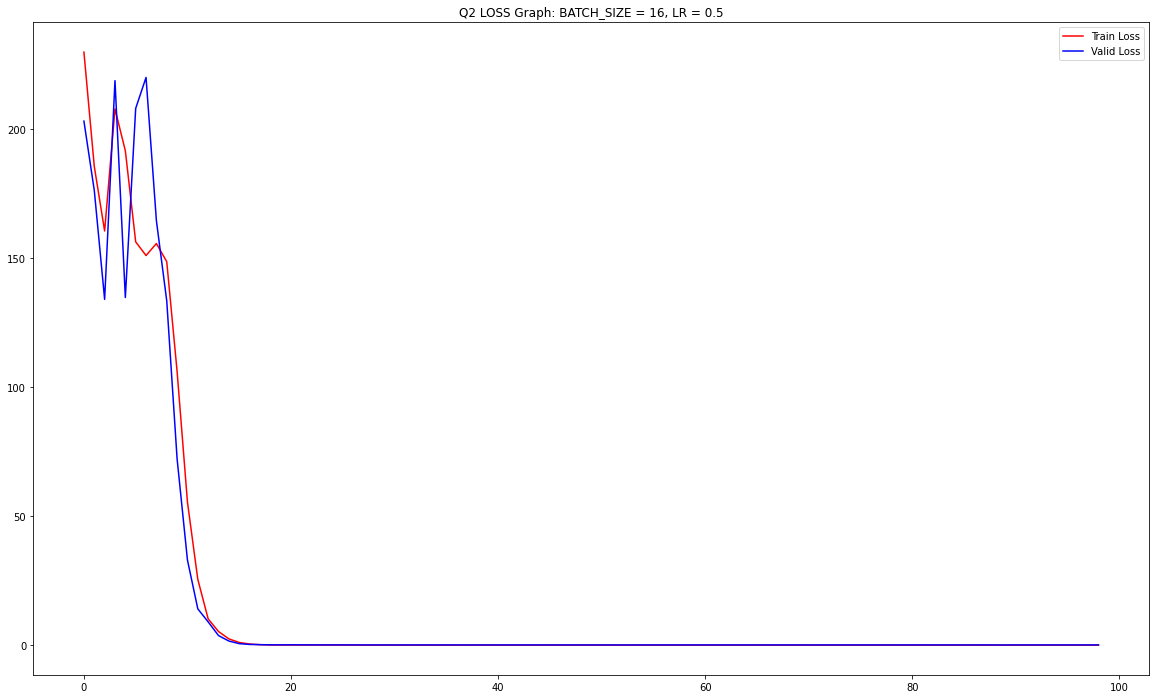

In [69]:
x = np.arange(len(train_loss[1:]))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss[1:], color='r', label='Train Loss')
plt.plot(x, valid_loss[1:], color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [70]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    num_outputs = params['num_outputs']
    truths, preds = [[], []], [[], []]
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for k in range(num_outputs):
            truths[k].extend(y[:, k, :].view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for k in range(num_outputs):
                preds[k].extend(y_hat[k, :, :].view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    for vals in [truths, preds]:
        vals[0] = vals[0] * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
        vals[1] = vals[1] * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    scores = pd.DataFrame(columns=['MAPE', 'MAE', 'MSE', 'R2 Score'])
    for k in range(num_outputs):
        scores.loc[k, 'MAPE'] = mape(truths[k], preds[k])
        scores.loc[k, 'MAE'] = MAE(truths[k], preds[k])
        scores.loc[k, 'MSE'] = MSE(truths[k], preds[k])
        scores.loc[k, 'R2 Score'] = r2_score(truths[k], preds[k])
    return truths, preds, scores

In [71]:
truths, preds, scores = test(params, test_loader, 'model_max.pth')

LSTM_multi(
  (lstm): LSTM(85, 512, num_layers=20, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


100%|██████████| 15/15 [00:00<00:00, 38.48it/s]


In [72]:
scores

,MAPE,MAE,MSE,R2 Score
0,15.725307,36940.140625,2004786816.0,-0.507547
1,55.130923,13.605757,295.70578,-0.874918


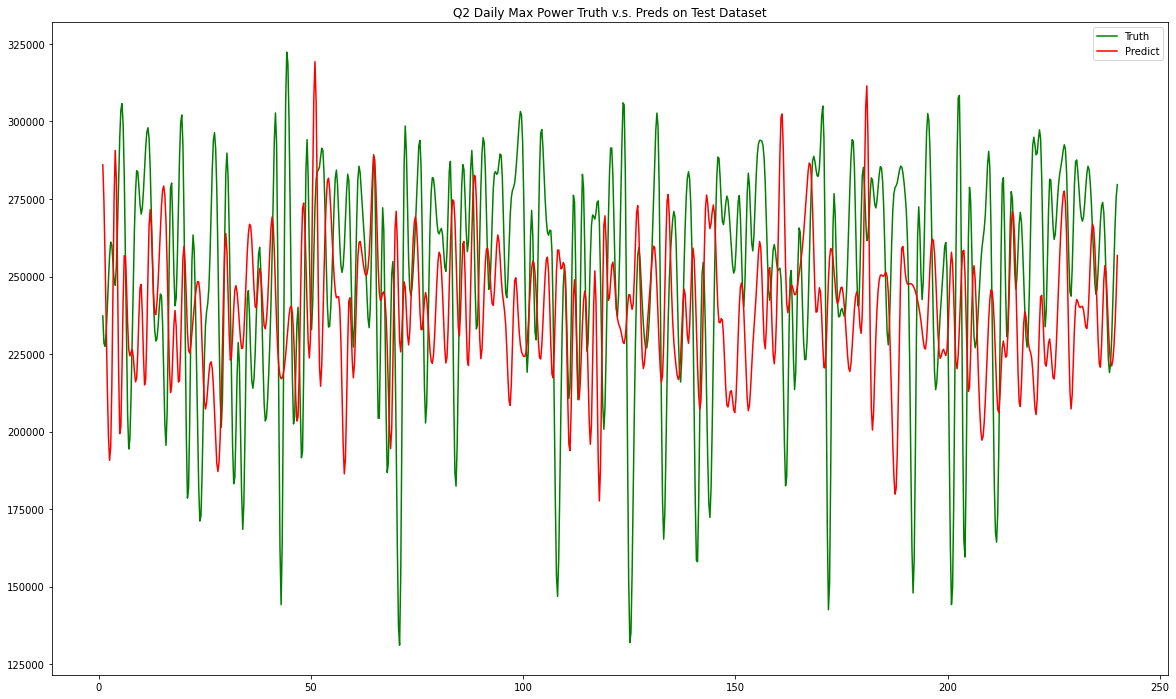

In [73]:
x = [i for i in range(1, len(truths[0]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[0])(x_smth)
preds_smth = make_interp_spline(x, preds[0])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Power Truth v.s. Preds on Test Dataset')
plt.show()

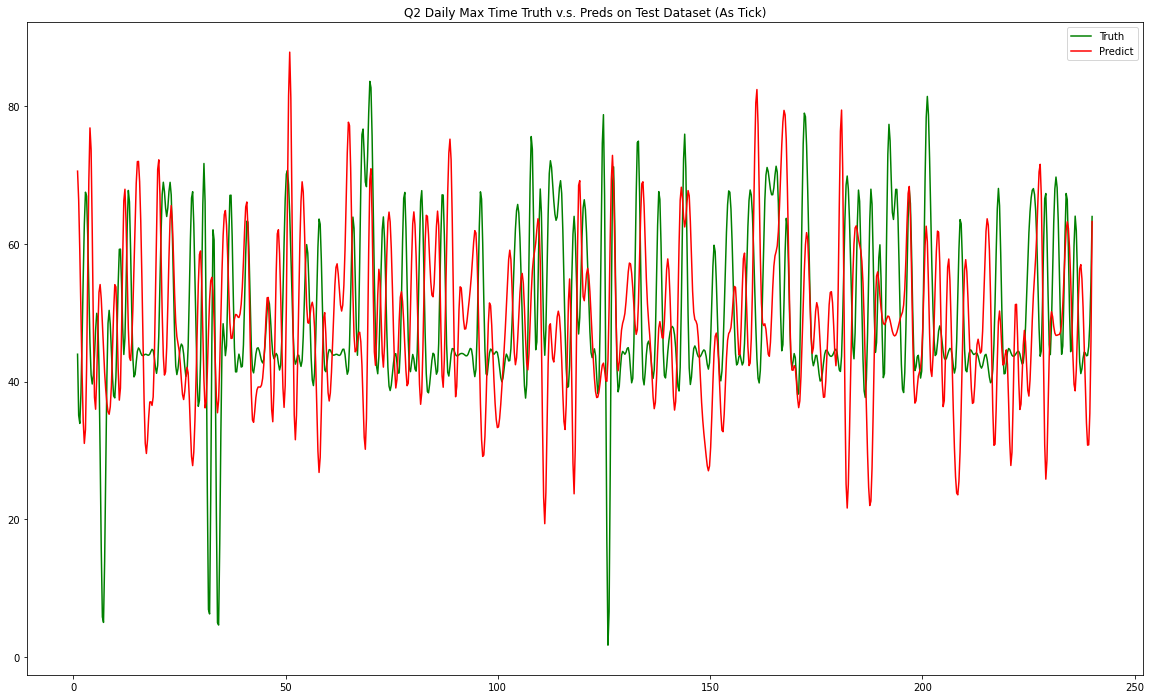

In [74]:
x = [i for i in range(1, len(truths[1]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[1])(x_smth)
preds_smth = make_interp_spline(x, preds[1])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Time Truth v.s. Preds on Test Dataset (As Tick)')
plt.show()

### 2.1.2 single-output LSTM and train twice Trail

#### 2.1.2.1 Train Model for Power

In [159]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, :1].reshape(1, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [160]:
window_size, predict_size = 14, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [161]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [162]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
#             if step == 0:
#                 print(y_hat, y)
            l = loss(y_hat, y)
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 100 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
#                 print(y_hat)
            l = loss(y_hat, y)
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            print('New best performance... Save new model checkpoint.')
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [163]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 256,
          'output_size': predict_size,
          'num_layers': 10, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 100}

In [164]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max_1.pth')

LSTM(
  (lstm): LSTM(87, 256, num_layers=50, batch_first=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Step 0, train loss 0.501629


  1%|          | 1/100 [00:04<07:29,  4.54s/it]

New best performance... Save new model checkpoint.
Epoch [1/100], train loss 62.718825, valid loss 27.519949. Now best: 27.519949
Step 0, train loss 49.535637


  2%|▏         | 2/100 [00:08<07:07,  4.37s/it]

New best performance... Save new model checkpoint.
Epoch [2/100], train loss 16.042630, valid loss 10.571916. Now best: 10.571916
Step 0, train loss 8.741491


  3%|▎         | 3/100 [00:13<06:58,  4.31s/it]

New best performance... Save new model checkpoint.
Epoch [3/100], train loss 6.471924, valid loss 2.748691. Now best: 2.748691
Step 0, train loss 4.107538


  4%|▍         | 4/100 [00:17<06:50,  4.28s/it]

New best performance... Save new model checkpoint.
Epoch [4/100], train loss 2.087090, valid loss 0.905827. Now best: 0.905827
Step 0, train loss 1.234491


  5%|▌         | 5/100 [00:21<06:34,  4.15s/it]

Epoch [5/100], train loss 0.998770, valid loss 0.960016. Now best: 0.905827
Step 0, train loss 0.902292


  6%|▌         | 6/100 [00:25<06:33,  4.18s/it]

New best performance... Save new model checkpoint.
Epoch [6/100], train loss 0.880683, valid loss 0.828032. Now best: 0.828032
Step 0, train loss 1.333431


  7%|▋         | 7/100 [00:29<06:23,  4.13s/it]

Epoch [7/100], train loss 0.813860, valid loss 0.846190. Now best: 0.828032
Step 0, train loss 1.253491


  8%|▊         | 8/100 [00:33<06:23,  4.17s/it]

Epoch [8/100], train loss 0.850588, valid loss 0.849707. Now best: 0.828032
Step 0, train loss 0.552355


  9%|▉         | 9/100 [00:37<06:20,  4.18s/it]

Epoch [9/100], train loss 0.814122, valid loss 0.982719. Now best: 0.828032
Step 0, train loss 0.475144


 10%|█         | 10/100 [00:42<06:20,  4.23s/it]

New best performance... Save new model checkpoint.
Epoch [10/100], train loss 0.821714, valid loss 0.756701. Now best: 0.756701
Step 0, train loss 0.759389


 11%|█         | 11/100 [00:46<06:15,  4.22s/it]

New best performance... Save new model checkpoint.
Epoch [11/100], train loss 0.806316, valid loss 0.743527. Now best: 0.743527
Step 0, train loss 0.398370


 12%|█▏        | 12/100 [00:50<05:59,  4.08s/it]

Epoch [12/100], train loss 0.771086, valid loss 0.826753. Now best: 0.743527
Step 0, train loss 0.771125


 13%|█▎        | 13/100 [00:54<06:02,  4.16s/it]

New best performance... Save new model checkpoint.
Epoch [13/100], train loss 0.880997, valid loss 0.665558. Now best: 0.665558
Step 0, train loss 0.435354


 14%|█▍        | 14/100 [00:58<05:47,  4.04s/it]

Epoch [14/100], train loss 0.820107, valid loss 0.849809. Now best: 0.665558
Step 0, train loss 0.680331


 15%|█▌        | 15/100 [01:02<05:36,  3.96s/it]

Epoch [15/100], train loss 0.822680, valid loss 1.021008. Now best: 0.665558
Step 0, train loss 0.804262


 16%|█▌        | 16/100 [01:06<05:43,  4.09s/it]

Epoch [16/100], train loss 0.810180, valid loss 0.836795. Now best: 0.665558
Step 0, train loss 0.886113


 17%|█▋        | 17/100 [01:10<05:31,  4.00s/it]

Epoch [17/100], train loss 0.798837, valid loss 0.961390. Now best: 0.665558
Step 0, train loss 0.420599


 18%|█▊        | 18/100 [01:14<05:24,  3.95s/it]

Epoch [18/100], train loss 0.833032, valid loss 0.854915. Now best: 0.665558
Step 0, train loss 0.538658


 19%|█▉        | 19/100 [01:18<05:19,  3.94s/it]

Epoch [19/100], train loss 0.817800, valid loss 0.817034. Now best: 0.665558
Step 0, train loss 1.167308


 20%|██        | 20/100 [01:21<05:10,  3.88s/it]

Epoch [20/100], train loss 0.813424, valid loss 0.930648. Now best: 0.665558
Step 0, train loss 0.487581


 21%|██        | 21/100 [01:26<05:19,  4.04s/it]

New best performance... Save new model checkpoint.
Epoch [21/100], train loss 0.801593, valid loss 0.657126. Now best: 0.657126
Step 0, train loss 1.247650


 22%|██▏       | 22/100 [01:30<05:16,  4.06s/it]

New best performance... Save new model checkpoint.
Epoch [22/100], train loss 0.776457, valid loss 0.650956. Now best: 0.650956
Step 0, train loss 0.888426


 23%|██▎       | 23/100 [01:34<05:06,  3.98s/it]

Epoch [23/100], train loss 0.764674, valid loss 0.673733. Now best: 0.650956
Step 0, train loss 0.898903


 24%|██▍       | 24/100 [01:38<05:11,  4.10s/it]

Epoch [24/100], train loss 0.796849, valid loss 0.779850. Now best: 0.650956
Step 0, train loss 0.754407


 25%|██▌       | 25/100 [01:42<04:59,  4.00s/it]

Epoch [25/100], train loss 0.834876, valid loss 0.888309. Now best: 0.650956
Step 0, train loss 0.363665


 26%|██▌       | 26/100 [01:46<04:52,  3.96s/it]

Epoch [26/100], train loss 0.832702, valid loss 0.842109. Now best: 0.650956
Step 0, train loss 0.499849


 27%|██▋       | 27/100 [01:50<04:48,  3.95s/it]

Epoch [27/100], train loss 0.839717, valid loss 0.848520. Now best: 0.650956
Step 0, train loss 0.936131


 28%|██▊       | 28/100 [01:53<04:42,  3.92s/it]

Epoch [28/100], train loss 0.744125, valid loss 0.929193. Now best: 0.650956
Step 0, train loss 0.551562


 29%|██▉       | 29/100 [01:57<04:36,  3.90s/it]

Epoch [29/100], train loss 0.801303, valid loss 0.860009. Now best: 0.650956
Step 0, train loss 0.497583


 30%|███       | 30/100 [02:01<04:32,  3.89s/it]

Epoch [30/100], train loss 0.810307, valid loss 0.780728. Now best: 0.650956
Step 0, train loss 0.580083


 31%|███       | 31/100 [02:05<04:26,  3.86s/it]

Epoch [31/100], train loss 0.791838, valid loss 0.898635. Now best: 0.650956
Step 0, train loss 0.916734


 32%|███▏      | 32/100 [02:09<04:28,  3.95s/it]

Epoch [32/100], train loss 0.844505, valid loss 0.815554. Now best: 0.650956
Step 0, train loss 0.880187


 33%|███▎      | 33/100 [02:13<04:23,  3.94s/it]

Epoch [33/100], train loss 0.897252, valid loss 1.084861. Now best: 0.650956
Step 0, train loss 0.814004


 34%|███▍      | 34/100 [02:17<04:18,  3.92s/it]

Epoch [34/100], train loss 0.775509, valid loss 0.883811. Now best: 0.650956
Step 0, train loss 1.672182


 35%|███▌      | 35/100 [02:21<04:15,  3.92s/it]

Epoch [35/100], train loss 0.867340, valid loss 0.891548. Now best: 0.650956
Step 0, train loss 0.944237


 36%|███▌      | 36/100 [02:25<04:08,  3.88s/it]

Epoch [36/100], train loss 0.806808, valid loss 0.824363. Now best: 0.650956
Step 0, train loss 1.084925


 37%|███▋      | 37/100 [02:28<04:02,  3.85s/it]

Epoch [37/100], train loss 0.831812, valid loss 0.889191. Now best: 0.650956
Step 0, train loss 0.885407


 38%|███▊      | 38/100 [02:32<04:00,  3.88s/it]

Epoch [38/100], train loss 0.857415, valid loss 0.847975. Now best: 0.650956
Step 0, train loss 0.835181


 39%|███▉      | 39/100 [02:36<03:55,  3.86s/it]

Epoch [39/100], train loss 0.790073, valid loss 1.117871. Now best: 0.650956
Step 0, train loss 1.237157


 40%|████      | 40/100 [02:40<03:53,  3.89s/it]

Epoch [40/100], train loss 0.876349, valid loss 0.913773. Now best: 0.650956
Step 0, train loss 0.869206


 41%|████      | 41/100 [02:44<03:55,  3.99s/it]

Epoch [41/100], train loss 0.855751, valid loss 0.888536. Now best: 0.650956
Step 0, train loss 0.556850


 42%|████▏     | 42/100 [02:48<03:48,  3.94s/it]

Epoch [42/100], train loss 0.787307, valid loss 0.873330. Now best: 0.650956
Step 0, train loss 0.719402


 43%|████▎     | 43/100 [02:52<03:47,  4.00s/it]

New best performance... Save new model checkpoint.
Epoch [43/100], train loss 0.769122, valid loss 0.622331. Now best: 0.622331
Step 0, train loss 0.582041


 44%|████▍     | 44/100 [02:56<03:44,  4.01s/it]

Epoch [44/100], train loss 0.784265, valid loss 0.878991. Now best: 0.622331
Step 0, train loss 1.467185


 45%|████▌     | 45/100 [03:00<03:37,  3.95s/it]

Epoch [45/100], train loss 0.767218, valid loss 0.891754. Now best: 0.622331
Step 0, train loss 0.813026


 46%|████▌     | 46/100 [03:04<03:30,  3.90s/it]

Epoch [46/100], train loss 0.879583, valid loss 0.637484. Now best: 0.622331
Step 0, train loss 0.810986


 47%|████▋     | 47/100 [03:08<03:26,  3.90s/it]

Epoch [47/100], train loss 0.759787, valid loss 0.791405. Now best: 0.622331
Step 0, train loss 0.860459


 48%|████▊     | 48/100 [03:12<03:23,  3.92s/it]

Epoch [48/100], train loss 0.845017, valid loss 0.696819. Now best: 0.622331
Step 0, train loss 0.955880


 49%|████▉     | 49/100 [03:16<03:24,  4.00s/it]

Epoch [49/100], train loss 0.849114, valid loss 0.812086. Now best: 0.622331
Step 0, train loss 0.812076


 50%|█████     | 50/100 [03:20<03:16,  3.93s/it]

Epoch [50/100], train loss 0.875502, valid loss 1.099793. Now best: 0.622331
Step 0, train loss 0.633328


 51%|█████     | 51/100 [03:23<03:10,  3.88s/it]

Epoch [51/100], train loss 0.793328, valid loss 0.866881. Now best: 0.622331
Step 0, train loss 0.688984


 52%|█████▏    | 52/100 [03:27<03:06,  3.90s/it]

Epoch [52/100], train loss 0.823646, valid loss 0.887647. Now best: 0.622331
Step 0, train loss 0.538669


 53%|█████▎    | 53/100 [03:31<03:00,  3.85s/it]

Epoch [53/100], train loss 0.829566, valid loss 0.715230. Now best: 0.622331
Step 0, train loss 1.100321


 54%|█████▍    | 54/100 [03:35<02:56,  3.85s/it]

Epoch [54/100], train loss 0.828365, valid loss 0.948708. Now best: 0.622331
Step 0, train loss 0.339345


 55%|█████▌    | 55/100 [03:39<02:54,  3.88s/it]

Epoch [55/100], train loss 0.812603, valid loss 0.805916. Now best: 0.622331
Step 0, train loss 0.916923


 56%|█████▌    | 56/100 [03:43<02:49,  3.85s/it]

Epoch [56/100], train loss 0.841525, valid loss 0.845021. Now best: 0.622331
Step 0, train loss 0.605559


 57%|█████▋    | 57/100 [03:47<02:49,  3.94s/it]

Epoch [57/100], train loss 0.831728, valid loss 0.891009. Now best: 0.622331
Step 0, train loss 1.093848


 58%|█████▊    | 58/100 [03:51<02:45,  3.94s/it]

Epoch [58/100], train loss 0.818472, valid loss 0.883605. Now best: 0.622331
Step 0, train loss 1.007289


 59%|█████▉    | 59/100 [03:55<02:41,  3.94s/it]

Epoch [59/100], train loss 0.857754, valid loss 0.801758. Now best: 0.622331
Step 0, train loss 1.040797


 60%|██████    | 60/100 [03:59<02:36,  3.91s/it]

Epoch [60/100], train loss 0.845679, valid loss 0.837376. Now best: 0.622331
Step 0, train loss 0.751186


 61%|██████    | 61/100 [04:02<02:32,  3.90s/it]

Epoch [61/100], train loss 0.781123, valid loss 1.039227. Now best: 0.622331
Step 0, train loss 0.603502


 62%|██████▏   | 62/100 [04:06<02:26,  3.86s/it]

Epoch [62/100], train loss 0.851829, valid loss 0.862806. Now best: 0.622331
Step 0, train loss 1.091856


 63%|██████▎   | 63/100 [04:10<02:22,  3.84s/it]

Epoch [63/100], train loss 0.855990, valid loss 0.826332. Now best: 0.622331
Step 0, train loss 0.475977


 64%|██████▍   | 64/100 [04:14<02:18,  3.86s/it]

Epoch [64/100], train loss 0.808831, valid loss 0.761465. Now best: 0.622331
Step 0, train loss 0.777985


 65%|██████▌   | 65/100 [04:18<02:17,  3.94s/it]

Epoch [65/100], train loss 0.869804, valid loss 1.006857. Now best: 0.622331
Step 0, train loss 0.509991


 66%|██████▌   | 66/100 [04:22<02:13,  3.94s/it]

Epoch [66/100], train loss 0.754830, valid loss 0.924965. Now best: 0.622331
Step 0, train loss 0.457062


 67%|██████▋   | 67/100 [04:26<02:08,  3.89s/it]

Epoch [67/100], train loss 0.800930, valid loss 0.791576. Now best: 0.622331
Step 0, train loss 0.913672


 68%|██████▊   | 68/100 [04:30<02:03,  3.86s/it]

Epoch [68/100], train loss 0.832764, valid loss 0.794743. Now best: 0.622331
Step 0, train loss 0.802146


 69%|██████▉   | 69/100 [04:33<02:00,  3.89s/it]

Epoch [69/100], train loss 0.830570, valid loss 0.915715. Now best: 0.622331
Step 0, train loss 0.453227


 70%|███████   | 70/100 [04:37<01:55,  3.85s/it]

Epoch [70/100], train loss 0.822509, valid loss 0.707099. Now best: 0.622331
Step 0, train loss 0.369814


 71%|███████   | 71/100 [04:41<01:50,  3.82s/it]

Epoch [71/100], train loss 0.767368, valid loss 0.785434. Now best: 0.622331
Step 0, train loss 0.644950


 72%|███████▏  | 72/100 [04:45<01:48,  3.86s/it]

Epoch [72/100], train loss 0.757117, valid loss 0.770785. Now best: 0.622331
Step 0, train loss 0.688266


 73%|███████▎  | 73/100 [04:49<01:46,  3.93s/it]

Epoch [73/100], train loss 0.830238, valid loss 0.847084. Now best: 0.622331
Step 0, train loss 1.643449


 74%|███████▍  | 74/100 [04:53<01:41,  3.89s/it]

Epoch [74/100], train loss 0.849202, valid loss 0.671193. Now best: 0.622331
Step 0, train loss 0.927786


 75%|███████▌  | 75/100 [04:57<01:37,  3.91s/it]

Epoch [75/100], train loss 0.851123, valid loss 0.849584. Now best: 0.622331
Step 0, train loss 1.144497


 76%|███████▌  | 76/100 [05:01<01:32,  3.85s/it]

Epoch [76/100], train loss 0.789874, valid loss 1.027534. Now best: 0.622331
Step 0, train loss 0.753220


 77%|███████▋  | 77/100 [05:04<01:28,  3.83s/it]

Epoch [77/100], train loss 0.874476, valid loss 0.823854. Now best: 0.622331
Step 0, train loss 0.449212


 78%|███████▊  | 78/100 [05:08<01:24,  3.85s/it]

Epoch [78/100], train loss 0.795373, valid loss 0.895284. Now best: 0.622331
Step 0, train loss 1.200849


 79%|███████▉  | 79/100 [05:12<01:20,  3.82s/it]

Epoch [79/100], train loss 0.796630, valid loss 0.900281. Now best: 0.622331
Step 0, train loss 0.264288


 80%|████████  | 80/100 [05:16<01:16,  3.82s/it]

Epoch [80/100], train loss 0.797951, valid loss 0.770224. Now best: 0.622331
Step 0, train loss 1.262010


 81%|████████  | 81/100 [05:20<01:15,  3.96s/it]

Epoch [81/100], train loss 0.868220, valid loss 0.809454. Now best: 0.622331
Step 0, train loss 1.450670


 82%|████████▏ | 82/100 [05:24<01:10,  3.91s/it]

Epoch [82/100], train loss 0.855388, valid loss 0.986154. Now best: 0.622331
Step 0, train loss 1.019166


 83%|████████▎ | 83/100 [05:28<01:06,  3.94s/it]

Epoch [83/100], train loss 0.857810, valid loss 0.714486. Now best: 0.622331
Step 0, train loss 1.266696


 84%|████████▍ | 84/100 [05:32<01:02,  3.88s/it]

Epoch [84/100], train loss 0.852070, valid loss 0.832706. Now best: 0.622331
Step 0, train loss 0.683532


 85%|████████▌ | 85/100 [05:35<00:57,  3.85s/it]

Epoch [85/100], train loss 0.844099, valid loss 0.760291. Now best: 0.622331
Step 0, train loss 0.838198


 86%|████████▌ | 86/100 [05:39<00:54,  3.88s/it]

Epoch [86/100], train loss 0.812931, valid loss 0.853042. Now best: 0.622331
Step 0, train loss 0.875432


 87%|████████▋ | 87/100 [05:43<00:49,  3.84s/it]

Epoch [87/100], train loss 0.757668, valid loss 1.040910. Now best: 0.622331
Step 0, train loss 0.780224


 88%|████████▊ | 88/100 [05:47<00:45,  3.82s/it]

Epoch [88/100], train loss 0.857325, valid loss 0.703246. Now best: 0.622331
Step 0, train loss 0.788440


 89%|████████▉ | 89/100 [05:51<00:44,  4.01s/it]

Epoch [89/100], train loss 0.824727, valid loss 0.755009. Now best: 0.622331
Step 0, train loss 1.009256


 90%|█████████ | 90/100 [05:55<00:39,  3.97s/it]

Epoch [90/100], train loss 0.788293, valid loss 1.037169. Now best: 0.622331
Step 0, train loss 1.146206


 91%|█████████ | 91/100 [05:59<00:35,  3.92s/it]

Epoch [91/100], train loss 0.734800, valid loss 0.882843. Now best: 0.622331
Step 0, train loss 0.377273


 92%|█████████▏| 92/100 [06:03<00:31,  3.92s/it]

Epoch [92/100], train loss 0.797790, valid loss 0.964346. Now best: 0.622331
Step 0, train loss 0.925051


 93%|█████████▎| 93/100 [06:07<00:27,  3.87s/it]

Epoch [93/100], train loss 0.833065, valid loss 0.875180. Now best: 0.622331
Step 0, train loss 1.264874


 94%|█████████▍| 94/100 [06:10<00:23,  3.86s/it]

Epoch [94/100], train loss 0.847543, valid loss 0.891331. Now best: 0.622331
Step 0, train loss 0.607043


 95%|█████████▌| 95/100 [06:14<00:19,  3.87s/it]

Epoch [95/100], train loss 0.824028, valid loss 0.925308. Now best: 0.622331
Step 0, train loss 0.994888


 96%|█████████▌| 96/100 [06:18<00:15,  3.83s/it]

Epoch [96/100], train loss 0.988276, valid loss 0.797268. Now best: 0.622331
Step 0, train loss 1.173963


 97%|█████████▋| 97/100 [06:22<00:11,  3.97s/it]

Epoch [97/100], train loss 0.814481, valid loss 0.798216. Now best: 0.622331
Step 0, train loss 0.782271


 98%|█████████▊| 98/100 [06:26<00:07,  3.93s/it]

Epoch [98/100], train loss 0.895218, valid loss 0.740328. Now best: 0.622331
Step 0, train loss 0.869207


 99%|█████████▉| 99/100 [06:30<00:03,  3.87s/it]

Epoch [99/100], train loss 0.751166, valid loss 0.901109. Now best: 0.622331
Step 0, train loss 1.301187


100%|██████████| 100/100 [06:34<00:00,  3.94s/it]

Epoch [100/100], train loss 0.831145, valid loss 0.705851. Now best: 0.622331


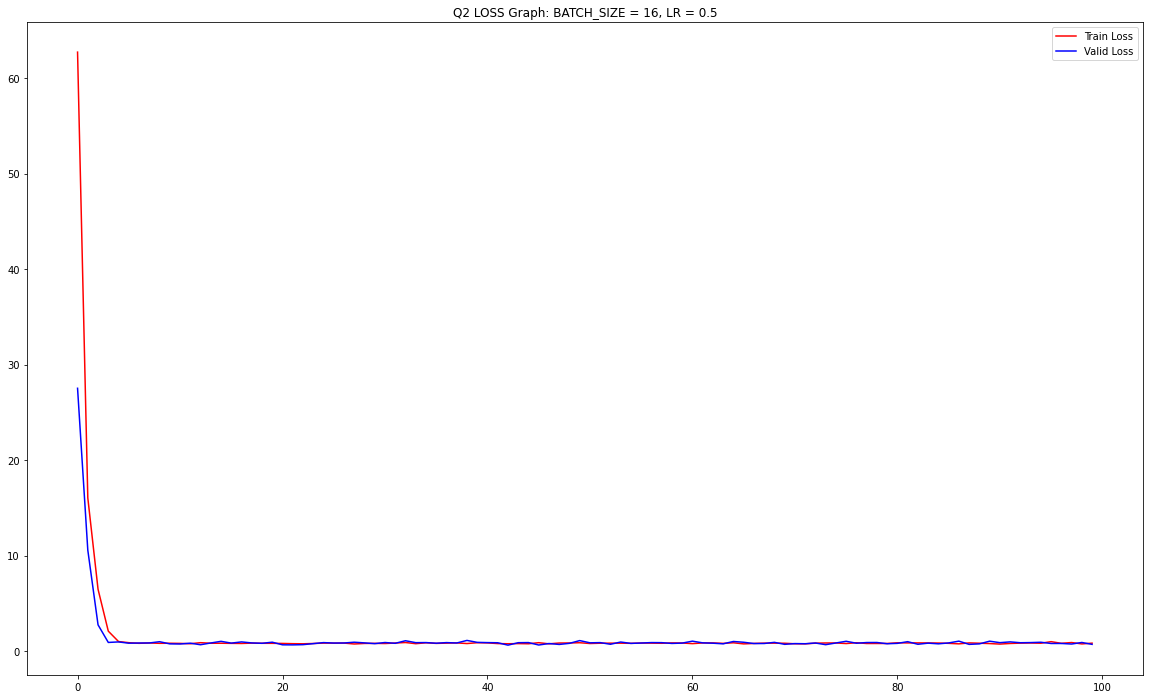

In [165]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [166]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        truths.extend(y.view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            preds.extend(y_hat.view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = truths * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
    preds = preds * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [167]:
truths, preds = test(params, test_loader, 'model_max_1.pth')

LSTM(
  (lstm): LSTM(87, 256, num_layers=50, batch_first=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)


100%|██████████| 15/15 [00:00<00:00, 30.83it/s]

MAPE: 51.4330267906189
MAE: 122289.766
MSE: 24893164000.0
R2 Score: -16.591963171846263


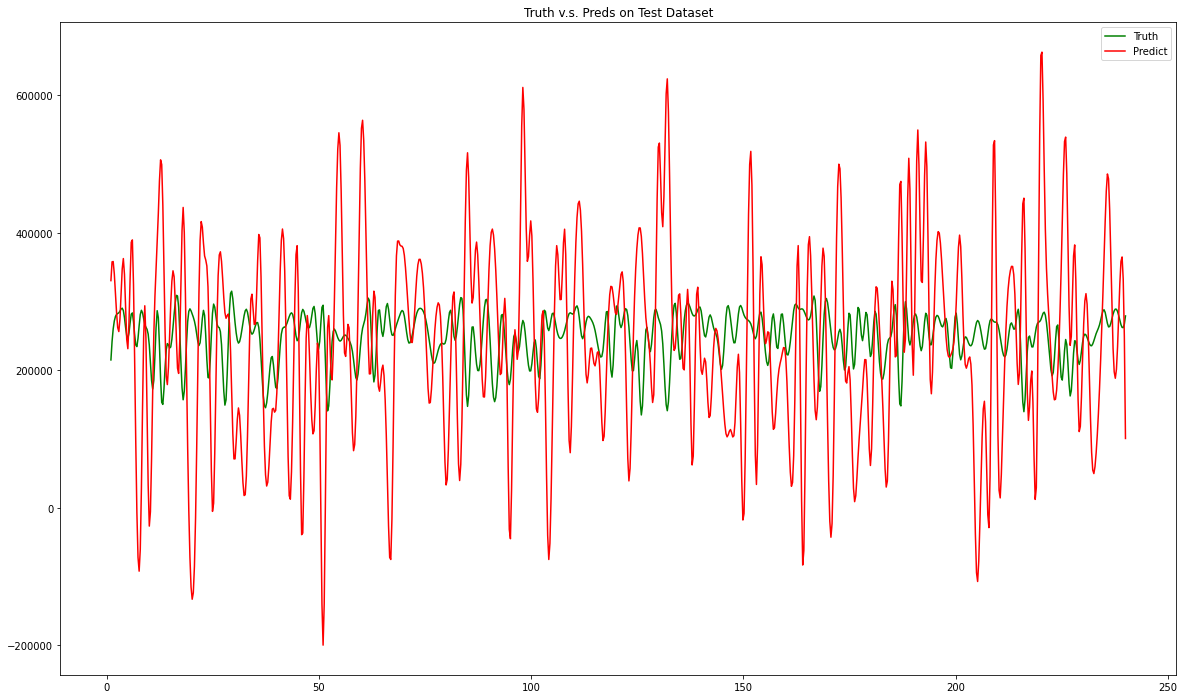

In [168]:
x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

#### 2.1.2.2 Train Model for Tick

In [169]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, 1:2].reshape(1, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [170]:
window_size, predict_size = 14, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [171]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [172]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 256,
          'output_size': predict_size,
          'num_layers': 40, 
          'learning_rate': 0.5,
          'weight_decay': 1e-3,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 100}

In [173]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max_2.pth')

LSTM(
  (lstm): LSTM(87, 128, num_layers=50, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.482523


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:03<05:34,  3.38s/it]

New best performance... Save new model checkpoint.
Epoch [1/100], train loss 18.122767, valid loss 0.603464. Now best: 0.603464
Step 0, train loss 0.147538


  2%|▏         | 2/100 [00:06<05:27,  3.34s/it]

Epoch [2/100], train loss 1.371250, valid loss 1.025637. Now best: 0.603464
Step 0, train loss 1.381112


  3%|▎         | 3/100 [00:10<05:34,  3.45s/it]

New best performance... Save new model checkpoint.
Epoch [3/100], train loss 0.259749, valid loss 0.179251. Now best: 0.179251
Step 0, train loss 0.028562


  4%|▍         | 4/100 [00:13<05:25,  3.40s/it]

Epoch [4/100], train loss 0.048650, valid loss 0.210277. Now best: 0.179251
Step 0, train loss 0.022131


  5%|▌         | 5/100 [00:17<05:31,  3.49s/it]

Epoch [5/100], train loss 0.034743, valid loss 0.184690. Now best: 0.179251
Step 0, train loss 0.272390


  6%|▌         | 6/100 [00:20<05:31,  3.52s/it]

Epoch [6/100], train loss 0.039906, valid loss 0.189747. Now best: 0.179251
Step 0, train loss 0.024610


  7%|▋         | 7/100 [00:24<05:20,  3.44s/it]

Epoch [7/100], train loss 0.034655, valid loss 0.182233. Now best: 0.179251
Step 0, train loss 0.033284


  8%|▊         | 8/100 [00:27<05:11,  3.39s/it]

Epoch [8/100], train loss 0.033996, valid loss 0.184518. Now best: 0.179251
Step 0, train loss 0.026472


  9%|▉         | 9/100 [00:30<05:11,  3.43s/it]

Epoch [9/100], train loss 0.034933, valid loss 0.180980. Now best: 0.179251
Step 0, train loss 0.025686


 10%|█         | 10/100 [00:34<05:07,  3.42s/it]

New best performance... Save new model checkpoint.
Epoch [10/100], train loss 0.038515, valid loss 0.173064. Now best: 0.173064
Step 0, train loss 0.017779


 11%|█         | 11/100 [00:37<05:00,  3.37s/it]

Epoch [11/100], train loss 0.111002, valid loss 0.195205. Now best: 0.173064
Step 0, train loss 0.033274


 12%|█▏        | 12/100 [00:40<04:58,  3.39s/it]

Epoch [12/100], train loss 0.033342, valid loss 0.182435. Now best: 0.173064
Step 0, train loss 0.019227


 13%|█▎        | 13/100 [00:44<04:54,  3.39s/it]

Epoch [13/100], train loss 0.033322, valid loss 0.185308. Now best: 0.173064
Step 0, train loss 0.021888


 14%|█▍        | 14/100 [00:47<04:49,  3.37s/it]

Epoch [14/100], train loss 0.035627, valid loss 0.173432. Now best: 0.173064
Step 0, train loss 0.060806


 15%|█▌        | 15/100 [00:51<04:53,  3.45s/it]

Epoch [15/100], train loss 0.033902, valid loss 0.180876. Now best: 0.173064
Step 0, train loss 0.030527


 16%|█▌        | 16/100 [00:54<04:49,  3.44s/it]

Epoch [16/100], train loss 0.033876, valid loss 0.180324. Now best: 0.173064
Step 0, train loss 0.063537


 17%|█▋        | 17/100 [00:58<04:42,  3.41s/it]

Epoch [17/100], train loss 0.038168, valid loss 0.181517. Now best: 0.173064
Step 0, train loss 0.030614


 18%|█▊        | 18/100 [01:01<04:36,  3.37s/it]

Epoch [18/100], train loss 0.033590, valid loss 0.186238. Now best: 0.173064
Step 0, train loss 0.036359


 19%|█▉        | 19/100 [01:04<04:36,  3.41s/it]

Epoch [19/100], train loss 0.053769, valid loss 0.185218. Now best: 0.173064
Step 0, train loss 0.018350


 20%|██        | 20/100 [01:08<04:30,  3.38s/it]

Epoch [20/100], train loss 0.032594, valid loss 0.222225. Now best: 0.173064
Step 0, train loss 0.044525


 21%|██        | 21/100 [01:11<04:24,  3.35s/it]

Epoch [21/100], train loss 0.034547, valid loss 0.182726. Now best: 0.173064
Step 0, train loss 0.019941


 22%|██▏       | 22/100 [01:14<04:24,  3.40s/it]

Epoch [22/100], train loss 0.040004, valid loss 0.181452. Now best: 0.173064
Step 0, train loss 0.035535


 23%|██▎       | 23/100 [01:18<04:35,  3.58s/it]

Epoch [23/100], train loss 0.033891, valid loss 0.177219. Now best: 0.173064
Step 0, train loss 0.021791


 23%|██▎       | 23/100 [01:22<04:36,  3.59s/it]


KeyboardInterrupt: 

In [ ]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [ ]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        truths.extend(y.view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            preds.extend(y_hat.view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = truths * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    preds = preds * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [ ]:
truths, preds = test(params, test_loader, 'model_max_2.pth')

In [ ]:
x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

## 2.2 For Daily Min